In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
file_path = '../Data/Processed/rating_numeric.csv'

## Data Preparation

First, we load the data from a CSV file and convert the `start_time` and `end_time` columns to the datetime format. We also drop the `appraisal` column since it is not numeric and won't be used in the analysis.

In [4]:
# Load data
data = pd.read_csv(file_path, header=0, index_col=[0, 1])

# Convert start_time and end_time to datetime format
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Drop the 'appraisal' column as it is non-numeric
data = data.drop(columns=['appraisal'])

### Display Basic Information

We display basic information about the dataset using the `info()` method. This provides an overview of the dataset, including the number of entries, column names, non-null counts, and data types for each column.

In [5]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3160 entries, ('5588b2bffdf99b7a7714efd1', 22) to ('6613a814a0c2d6cb21da8ef8', 478)
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_time          3160 non-null   datetime64[ns]
 1   end_time            3160 non-null   datetime64[ns]
 2   wander_speed        3160 non-null   float64       
 3   wander_roundness    3160 non-null   float64       
 4   wander_cycle_rate   3160 non-null   float64       
 5   blink_temperature   3160 non-null   float64       
 6   blink_slope         3160 non-null   float64       
 7   blink_cycle_rate    3160 non-null   float64       
 8   beep_pitch          3160 non-null   float64       
 9   beep_slope          3160 non-null   float64       
 10  beep_cycle_rate     3160 non-null   float64       
 11  joy_intensity       3160 non-null   float64       
 12  sadness_intensity   3160 non-null   float64 

We use the `describe()` method to generate a statistical summary of all numeric columns in the dataset.

In [6]:
data.describe(include=np.number)

,wander_speed,wander_roundness,wander_cycle_rate,blink_temperature,blink_slope,blink_cycle_rate,beep_pitch,beep_slope,beep_cycle_rate,joy_intensity,sadness_intensity,fear_intensity,anger_intensity,disgust_intensity,surprise_intensity,pleasure,arousal,dominance
count,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000
mean,64.921428,0.499199,3.243139,0.499988,0.000949,3.246414,549.134563,0.001582,3.251742,1.720570,1.555696,1.461709,1.125949,0.875949,1.480380,4.341772,5.107595,4.447468
std,20.211122,0.289483,1.587420,0.289394,0.708336,1.586113,260.310957,0.708782,1.583781,1.584615,1.515374,1.502069,1.335216,1.172030,1.406671,2.343343,2.112492,2.145638
min,30.059533,0.000103,0.502657,0.000461,-1.000000,0.506117,100.388060,-1.000000,0.506093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,47.437881,0.246311,1.868632,0.248100,-1.000000,1.874930,323.997898,-1.000000,1.878336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000
50%,64.747286,0.497217,3.229217,0.501358,0.000000,3.248918,548.284312,0.000000,3.251068,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,5.000000,5.000000
75%,82.412757,0.749371,4.614483,0.750929,1.000000,4.617121,773.537894,1.000000,4.616167,3.000000,3.000000,3.000000,2.000000,1.000000,3.000000,6.000000,7.000000,6.000000
max,99.990994,0.998869,5.994862,0.998560,1.000000,5.993133,999.495559,1.000000,5.999463,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


And we print the data to inspect it.

In [7]:
data

start_time            end_time  \
participant_id           video_id                                           
5588b2bffdf99b7a7714efd1 22       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         43       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         50       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         84       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         125      2024-05-08 22:59:00 2024-05-08 23:40:00   
...                                               ...                 ...   
6613a814a0c2d6cb21da8ef8 279      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         387      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         423      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         467      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         478      2024-05-08 21:33:00 2024-05-08 22:09:00   

                                   wander_speed  wander_roundness  \
participant_id           video_id                                   
5588b2bffdf99b7a7714efd1 22           62.775115          0.688911   
                         43           61.110970          0.352980   
                         50           46.017272          0.530403   
                         84           78.659842          0.963506   
                         125          74.946312          0.498299   
...                                         ...               ...   
6613a814a0c2d6cb21da8ef8 279          30.321874          0.203517   
                         387          52.342993          0.496135   
                         423          37.922254          0.283549   
                         467          49.408758          0.420447   
                         478          55.832759          0.652202   

                                   wander_cycle_rate  blink_temperature  \
participant_id           video_id                                         
5588b2bffdf99b7a7714efd1 22                 3.862264           0.504496   
                         43                 4.637822           0.929641   
                         50                 3.425497           0.943638   
                         84                 4.025686           0.931626   
                         125                3.467634           0.330719   
...                                              ...                ...   
6613a814a0c2d6cb21da8ef8 279                5.904459           0.464465   
                         387                2.325440           0.086675   
                         423                1.888757           0.400462   
                         467                4.809581           0.447571   
                         478                2.657507           0.231250   

                                   blink_slope  blink_cycle_rate  beep_pitch  \
participant_id           video_id                                              
5588b2bffdf99b7a7714efd1 22                0.0          4.403772  123.816519   
                         43                0.0          3.738390  773.537894   
                         50                1.0          2.511475  598.384259   
                         84                0.0          0.646983  689.681266   
                         125              -1.0          5.915387  764.680016   
...                                        ...               ...         ...   
6613a814a0c2d6cb21da8ef8 279              -1.0          5.540890  744.226868   
                         387               1.0          3.799604  586.635677   
                         423               0.0          2.939068  105.036834   
                         467              -1.0          1.632404  687.165981   
                         478               0.0          0.506117  517.980755   

                                   beep_slope  beep_cycle_rate  joy_intensity  \
participant_id           video_id            

Next, we define the lists of independent and dependent variables. These will be used later in the analysis.

In [8]:
# Define the emotion intensities columns
intensity_columns = [
    'joy_intensity', 'sadness_intensity', 'anger_intensity', 
    'fear_intensity', 'disgust_intensity', 'surprise_intensity'
]

# Define the SAM columns
sam_columns = ['pleasure', 'arousal', 'dominance']

# Define the dependent variables
dependent_vars = intensity_columns + sam_columns

# Define the independent variables continuous independent variables
independent_vars = [
    'wander_speed', 'wander_roundness', 'wander_cycle_rate', 
    'blink_temperature', 'blink_slope', 'blink_cycle_rate', 
    'beep_pitch', 'beep_slope', 'beep_cycle_rate'
]

# Specify which of the independent variables are continuous
independent_continuous_vars = [
    'wander_speed', 'wander_roundness', 'wander_cycle_rate', 
    'blink_temperature', 'blink_cycle_rate', 
    'beep_pitch', 'beep_cycle_rate'
]

### Remove Outliers

We define a function to detect and remove outliers from the dataset using the Interquartile Range (IQR) method. The function calculates the IQR for each specified column and removes data points that fall below the lower bound or above the upper bound (1.5 times the IQR from the first and third quartiles). We then apply this function to the dependent variables to clean the data. The resulting dataset consists of 2775 data points. 

In [9]:
# Function to detect and remove outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers from the dependent variables
cleaned_data = remove_outliers(data, dependent_vars)

cleaned_data

start_time            end_time  \
participant_id           video_id                                           
5588b2bffdf99b7a7714efd1 22       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         43       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         50       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         125      2024-05-08 22:59:00 2024-05-08 23:40:00   
                         133      2024-05-08 22:59:00 2024-05-08 23:40:00   
...                                               ...                 ...   
6613a814a0c2d6cb21da8ef8 276      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         279      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         387      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         423      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         478      2024-05-08 21:33:00 2024-05-08 22:09:00   

                                   wander_speed  wander_roundness  \
participant_id           video_id                                   
5588b2bffdf99b7a7714efd1 22           62.775115          0.688911   
                         43           61.110970          0.352980   
                         50           46.017272          0.530403   
                         125          74.946312          0.498299   
                         133          69.997794          0.156824   
...                                         ...               ...   
6613a814a0c2d6cb21da8ef8 276          79.267659          0.904226   
                         279          30.321874          0.203517   
                         387          52.342993          0.496135   
                         423          37.922254          0.283549   
                         478          55.832759          0.652202   

                                   wander_cycle_rate  blink_temperature  \
participant_id           video_id                                         
5588b2bffdf99b7a7714efd1 22                 3.862264           0.504496   
                         43                 4.637822           0.929641   
                         50                 3.425497           0.943638   
                         125                3.467634           0.330719   
                         133                1.091686           0.610203   
...                                              ...                ...   
6613a814a0c2d6cb21da8ef8 276                5.033423           0.043467   
                         279                5.904459           0.464465   
                         387                2.325440           0.086675   
                         423                1.888757           0.400462   
                         478                2.657507           0.231250   

                                   blink_slope  blink_cycle_rate  beep_pitch  \
participant_id           video_id                                              
5588b2bffdf99b7a7714efd1 22                0.0          4.403772  123.816519   
                         43                0.0          3.738390  773.537894   
                         50                1.0          2.511475  598.384259   
                         125              -1.0          5.915387  764.680016   
                         133               0.0          1.923220  838.228934   
...                                        ...               ...         ...   
6613a814a0c2d6cb21da8ef8 276               1.0          2.865431  428.076560   
                         279              -1.0          5.540890  744.226868   
                         387               1.0          3.799604  586.635677   
                         423               0.0          2.939068  105.036834   
                         478               0.0          0.506117  517.980755   

                                   beep_slope  beep_cycle_rate  joy_intensity  \
participant_id           video_id            

And we create a dictionary of titles which will be used for plotting figures.

In [10]:
titles = {'wander_speed': 'Wander Speed', 'wander_roundness': 'Wander Roundness', 'wander_roundness_effective': 'Wander Effective Roundness', 'wander_cycle_rate': 'Wander Cycle Rate', 
          'blink_temperature': 'Blink Temperature', 'blink_slope': 'Blink Slope', 'blink_cycle_rate': 'Blink Cycle Rate', 
          'beep_pitch': 'Beep Pitch', 'beep_slope': 'Beep Slope', 'beep_cycle_rate': 'Beep Cycle Rate',
          'joy_intensity': 'Joy Intensity', 'sadness_intensity': 'Sadness Intensity', 'anger_intensity': 'Anger Intensity', 
          'fear_intensity': 'Fear Intensity', 'disgust_intensity': 'Disgust Intensity', 'surprise_intensity': 'Surprise Intensity',
          'pleasure': 'Pleasure', 'arousal': 'Arousal', 'dominance': 'Dominance'}

## Exploratory Data Analysis

### Visualize Distributions of Independent Variables

To start off the exploratory data analysis, we create a grid of histograms to visualize the distributions of the independent variables. This helps us understand the distribution and spread of each variable. 

As you can see, the distribution of the independent variables is pretty uniform for the continuous independent variables. This is good, as it will help us ensure that we cover the range of possible values as uniformly as possible.

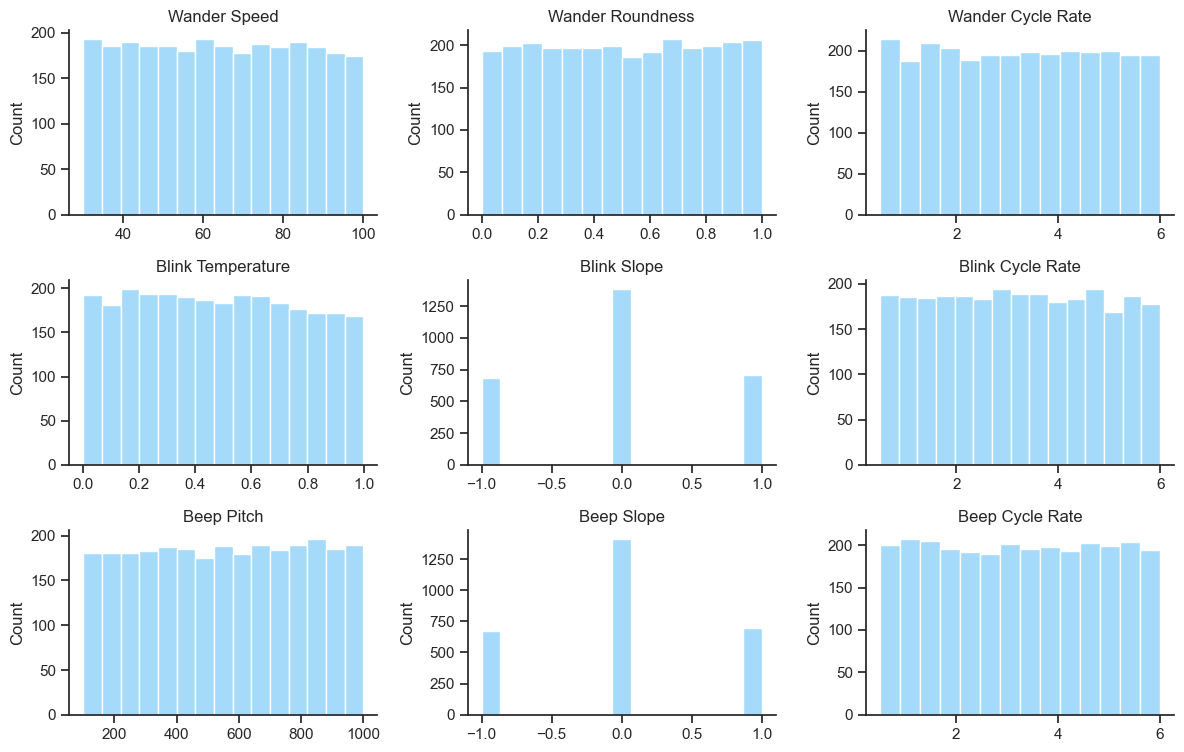

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for ax, independent_var in zip(axes.flatten(), independent_vars):
    # Create the histplot in the specified subplot
    sns.histplot(data=cleaned_data, x=independent_var, ax=ax, color='lightskyblue')
    ax.set_title(titles[independent_var])
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Visualize Distributions of Dependent Variables

Next, we create a grid of count plots to visualize the distributions of the emotion intensity variables. This helps us understand the distribution of the intensities for each emotion:

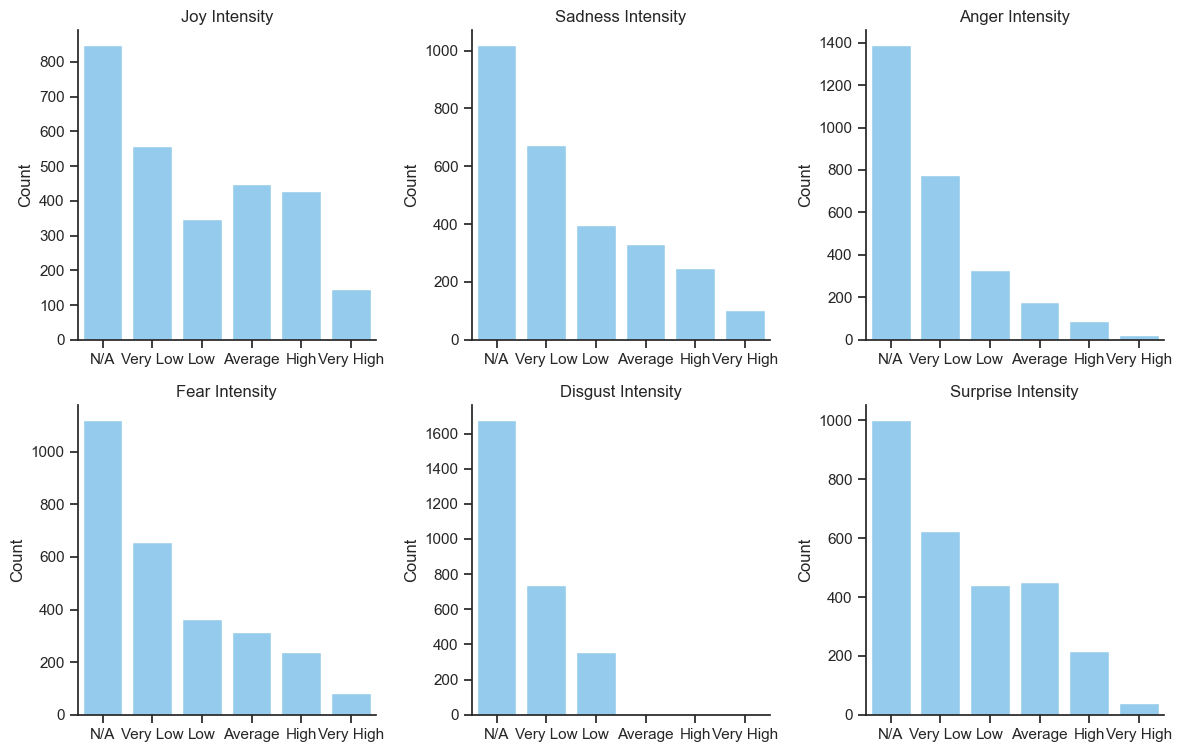

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, dependent_var in zip(axes.flatten(), intensity_columns):
    # Create the catplot in the specified subplot
    sns.countplot(data=cleaned_data, x=dependent_var, ax=ax, color='lightskyblue')
    ax.set_title(titles[dependent_var])
    ax.set_xlabel('')
    ax.set_xlim(-0.5, 5.5)
    ax.set_xticks(range(6))
    ax.set_xticklabels(['N/A', 'Very Low', 'Low', 'Average', 'High', 'Very High'])
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Next, we create a grid of count plots to visualize the distributions of the Self-Assessment Manikin columns:

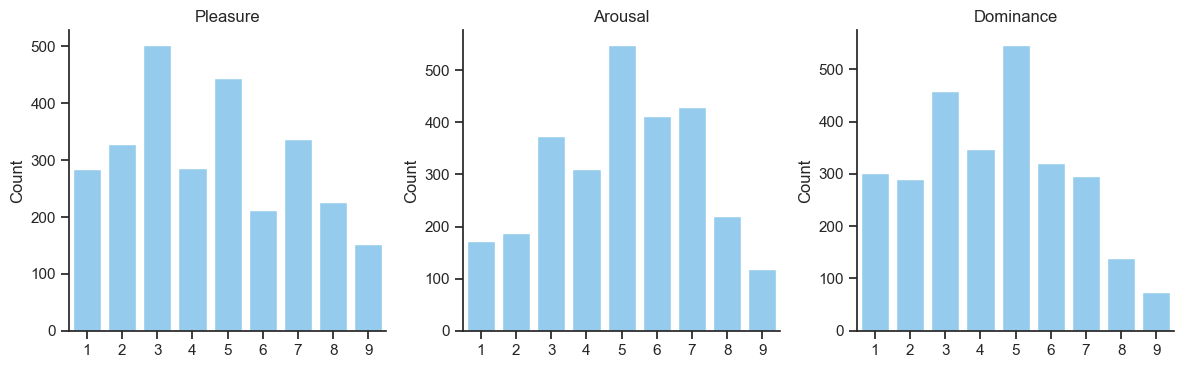

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, dependent_var in zip(axes.flatten(), sam_columns):
    # Create the catplot in the specified subplot
    sns.countplot(data=cleaned_data, x=dependent_var, ax=ax, color='lightskyblue')
    ax.set_title(titles[dependent_var])
    ax.set_xlabel('')
    ax.set_xticks(range(9))
    ax.set_xticklabels(range(1,10))
    ax.set_ylabel('Count')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Modelling

### Correlation Analysis

We compute the correlation matrix for the independent and dependent variables using Pearson's correlation method:

In [14]:
corr_matrix = cleaned_data[independent_vars + dependent_vars].corr(method='pearson')

Next, we define a function to perform Pearson correlation tests between each pair of independent and dependent variables. This function also supports multiple testing corrections:

In [15]:
def pearson_test(df, independent_vars, dependent_vars, alpha=0.05, bonferroni_correction=False, benjamini_hochberg_correction=False):
    data = []
    p_values_non_zero = []
    p_values_positive = []
    p_values_negative = []

    if bonferroni_correction and benjamini_hochberg_correction:
        raise Exception("You can only apply one multiple-testing correction.")
    elif bonferroni_correction:
        method = 'bonferroni'
    elif benjamini_hochberg_correction:
        method = 'fdr_bh'
    else:
        method = None  # No correction

    for independent_var in independent_vars:
        for dependent_var in dependent_vars:
            # Calculate Spearman correlation for two-sided test
            rho, p_non_zero = stats.pearsonr(df[independent_var], df[dependent_var], alternative='two-sided')
            
            # Calculate Spearman correlation for one-sided tests
            _, p_negative = stats.pearsonr(df[independent_var], df[dependent_var], alternative='less')
            _, p_positive = stats.pearsonr(df[independent_var], df[dependent_var], alternative='greater')

            # Collect p-values for later adjustment
            p_values_non_zero.append(p_non_zero)
            p_values_positive.append(p_positive)
            p_values_negative.append(p_negative)
            
            # Store the initial results
            row = {'independent_variable': independent_var, 'dependent_variable': dependent_var, 'correlation': rho, 
                   'p_non_zero': p_non_zero, 'is_non_zero': p_non_zero < alpha, 
                   'p_positive': p_positive, 'is_positive': p_positive < alpha / 2, 
                   'p_negative': p_negative, 'is_negative': p_negative < alpha / 2}
            
            data.append(row)
    
    # Convert the list of dictionaries to a DataFrame
    correlation_test_results_df = pd.DataFrame(data)
    
    if method:
        # Apply multiple testing correction
        correlation_test_results_df['is_non_zero'] = multipletests(p_values_non_zero, alpha=alpha, method=method)[0]
        correlation_test_results_df['is_positive'] = multipletests(p_values_positive, alpha=alpha, method=method)[0]
        correlation_test_results_df['is_negative'] = multipletests(p_values_negative, alpha=alpha, method=method)[0]

    correlation_test_results_df.set_index(['independent_variable', 'dependent_variable'], inplace=True)

    return correlation_test_results_df

Next, we define a helper function to annotate the significant correlations in the correlation matrix. This function adds asterisks to indicate statistical significance.

In [16]:
def get_correlation_annots(correlation_test_results_df):
    correlation_test_results_array = correlation_test_results_df.correlation.to_numpy()
    annot = correlation_test_results_array.astype(str)
    indexed_correlation_test_results_df = correlation_test_results_df.reset_index()
    significance_mask = indexed_correlation_test_results_df[indexed_correlation_test_results_df['is_non_zero'] & (indexed_correlation_test_results_df['is_positive'] | indexed_correlation_test_results_df['is_negative'])].index
    
    # Apply asterisks to significant correlations
    for i in range(len(correlation_test_results_array)):
        if i in significance_mask:
            annot[i] = f'{correlation_test_results_array[i]:.3f}*'
        else:
            annot[i] = f'{correlation_test_results_array[i]:.3f}'
    
    annot = annot.reshape(9, 9).T

    return annot

#### Correlation Matrix of the Independent Variables

We then create a heatmap to visualize the correlation matrix of the independent variables. This visualization helps us identify the strength and direction of linear relationships between pairs of variables. The heatmap shows that most independent variables have very low correlation with each other, indicating very low multicollinearity.

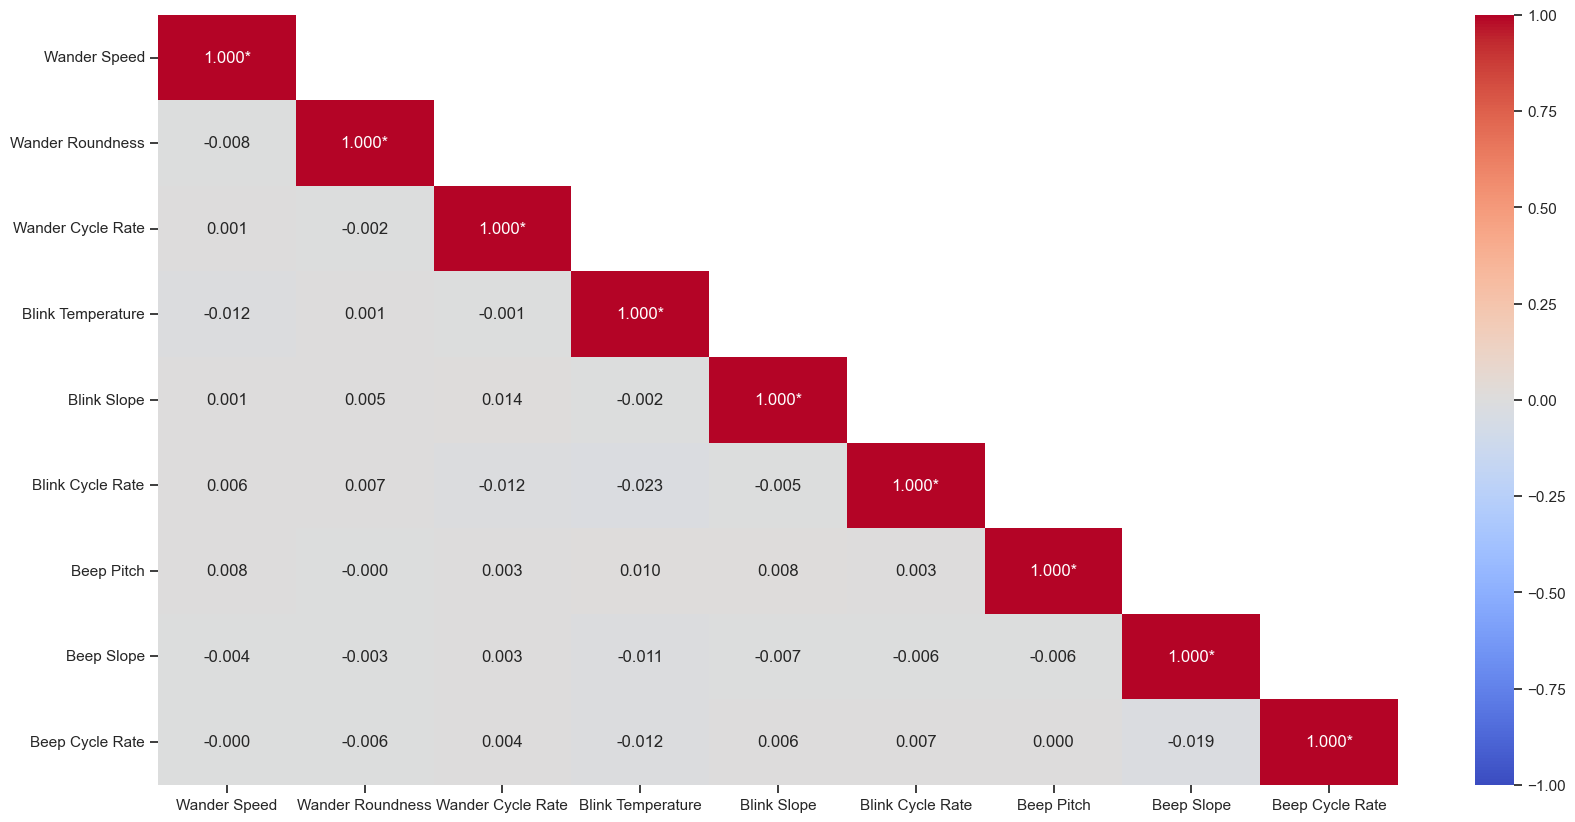

In [17]:
correlation_test_results_df = pearson_test(cleaned_data, independent_vars, independent_vars)
annot = get_correlation_annots(correlation_test_results_df)

plt.figure(figsize=(20, 10))
ticklabels = [titles[var] for var in independent_vars]
sns.heatmap(corr_matrix.iloc[:9, :9], mask=np.triu(np.ones_like(corr_matrix.iloc[:9, :9], dtype=bool), k=1), annot=annot, xticklabels=ticklabels, yticklabels=ticklabels, cmap='coolwarm', fmt='', center=0, vmin=-1, vmax=1)
plt.show()

#### Correlation Matrix of the Dependent Variables

We do the same for the dependent variables. The heatmap shows several meaningful correlations among the dependent variables, indicating that participants understood the assignment of rating the emotions:

- **Positive Correlations**:
  - **Pleasure and Joy Intensity**: There is a strong positive correlation (0.808*), which makes sense as joy is a high-pleasure emotion.
  - **Disgust Intensity and Anger Intensity**: There is a positive correlation (0.509*), indicating that participants often perceive these emotions together.
  - **Arousal and Dominance**: There is a positive correlation (0.506*), suggesting that higher arousal is associated with higher feelings of dominance.

- **Negative Correlations**:
  - **Pleasure and Sadness Intensity**: There is a strong negative correlation (-0.534*), which is expected as sadness is a low-pleasure emotion.
  - **Pleasure and Fear Intensity**: There is a negative correlation (-0.450*), indicating that higher fear is associated with lower pleasure.

These correlations align with psychological theories of emotions, suggesting that the participants understood and correctly rated the emotions. If we had seen unexpected results, such as a negative correlation between joy and pleasure, it could indicate issues with data quality or participant understanding.

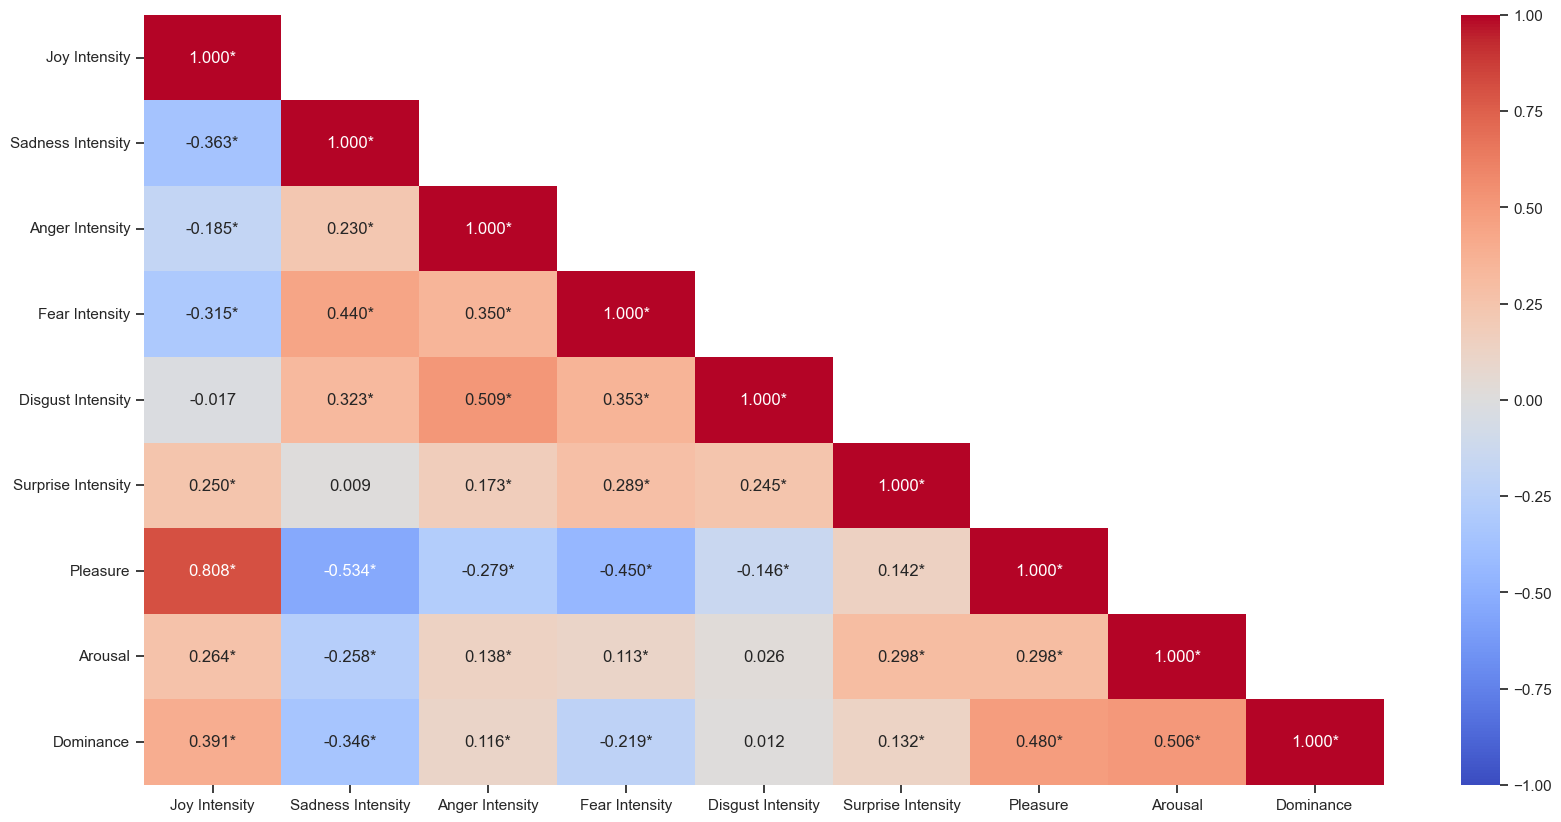

In [18]:
correlation_test_results_df = pearson_test(cleaned_data, dependent_vars, dependent_vars)
annot = get_correlation_annots(correlation_test_results_df)

plt.figure(figsize=(20, 10))
ticklabels = [titles[var] for var in dependent_vars]
sns.heatmap(corr_matrix.iloc[9:, 9:], mask=np.triu(np.ones_like(corr_matrix.iloc[9:, 9:], dtype=bool), k=1), annot=annot, xticklabels=ticklabels, yticklabels=ticklabels, cmap='coolwarm', fmt='', center=0, vmin=-1, vmax=1)
plt.show()

#### Correlation Matrix of the Independent and the Dependent Variables

Finally, we do the same for each pair of independent and dependent variables. The heatmap shows that most correlations between the independent and dependent variables are relatively weak, suggesting that the independent variables may not have strong predictive power for the dependent variables if a linear regression model is used. Notable correlations include:

- **Arousal and Wander Speed**: There is a positive correlation (0.313*), indicating that higher wander speeds are associated with higher arousal.
- **Sadness Intensity and Wander Speed**: There is a negative correlation (-0.148*), suggesting that higher wander speeds are associated with lower sadness intensity.
- **Surprise Intensity and Wander Speed**: There is a positive correlation (0.146*), suggesting that higher wander speeds are associated with higher surprise intensity.

These weak correlations imply that while the independent variables may not be strong linear predictors, exploring feature engineering and using models that can handle non-linear patterns could potentially improve predictive performance.

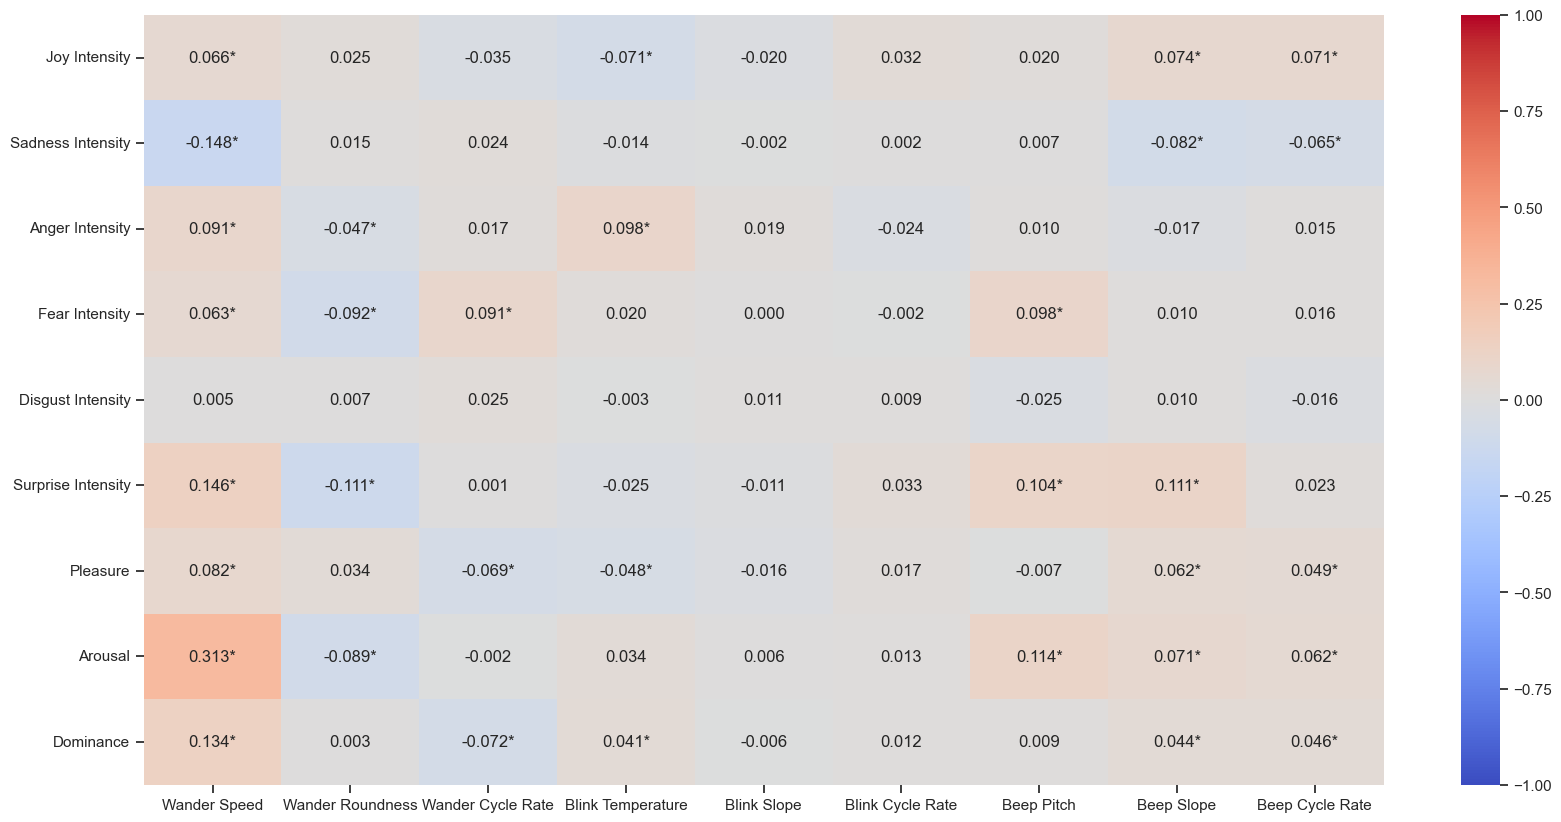

In [19]:
correlation_test_results_df = pearson_test(cleaned_data, independent_vars, dependent_vars)
annot = get_correlation_annots(correlation_test_results_df)

plt.figure(figsize=(20, 10))
xticklabels = [titles[var] for var in independent_vars]
yticklabels = [titles[var] for var in dependent_vars]
sns.heatmap(corr_matrix.iloc[9:, :9], annot=annot, xticklabels=xticklabels, yticklabels=yticklabels, cmap='coolwarm', fmt='', center=0, vmin=-1, vmax=1)
plt.show()

### Model Training 

To predict the dependent variables, we will create regression models using a cross-validation approach. We will use the function `k_folds_training` below to perform K-Fold cross-validation.

#### Forced Entry of Variables 
All models have been trained with forced entry of all independent variables and engineered features. This means that all variables are included in the model without performing any stepwise regression.


- **Advantages**:
    - Simplicity: This approach simplifies the modeling process as all variables are included without the need for iterative selection procedures.
    - Captures Full Feature Set: Ensures that all potential predictors and interactions are considered in the model.
- **Disadvantages**:
    - Overfitting Risk: Including all variables and interactions increases the complexity of the model, which can lead to overfitting, especially with a large number of features.
    - Irrelevant Features: The model may include irrelevant features that do not contribute to predictive power, potentially degrading performance.

#### Performance Metrics

This function performs 5-fold cross-validation, providing a robust evaluation of model performance by training and testing the model on different subsets of the data. The average Mean Squared Error (`avg_mse_scores`) and average R² (`avg_r2`) values are computed to assess model accuracy and explanatory power in both the training and testing data:

- **Train MSE and R²**: These metrics show how well the model fits the training data. High R² and low MSE values indicate good fit.
- **Test MSE and R²**: These metrics show how well the model generalizes to unseen data. A significant difference between train and test metrics may indicate overfitting or underfitting.


#### Models Used

We will use three types of models for the following reasons:

1. **Linear Regression Model**:
   - Simple and interpretable.
   - Good for understanding linear relationships.
2. **Random Forest Regressor**:
   - Capable of capturing non-linear relationships.
   - Robust to overfitting with default settings and parameter tuning.
3. **Simple Neural Network**:
   - Powerful for capturing complex, non-linear patterns.
   - Composed of layers of neurons with activation functions.

In [20]:
def k_folds_training(model, X, y, **kwargs):
    # Perform K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    train_mse_scores = []
    test_mse_scores = []
    train_r2_scores = []
    test_r2_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train, **kwargs)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred, multioutput='raw_values'))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
        
        train_r2_scores.append(r2_score(y_train, y_train_pred, multioutput='variance_weighted'))
        test_r2_scores.append(r2_score(y_test, y_test_pred, multioutput='variance_weighted'))

    # Dynamically determine the dependent variables
    mask = np.any(np.array([['joy' in column for column in y.columns],
                            ['sadness' in column for column in y.columns],
                            ['anger' in column for column in y.columns],
                            ['fear' in column for column in y.columns],
                            ['disgust' in column for column in y.columns],
                            ['surprise' in column for column in y.columns],
                            ['pleasure' in column for column in y.columns],
                            ['arousal' in column for column in y.columns],
                            ['dominance' in column for column in y.columns]]), axis=1)
                                   
    dependent_vars = list(y.columns[mask])
    
    # Calculate average scores across all folds
    avg_train_mse_scores = {dependent_var: round(avg_train_mse_score, 3) for dependent_var, avg_train_mse_score in zip(dependent_vars, np.mean(train_mse_scores, axis=0))}
    avg_test_mse_scores = {dependent_var: round(avg_test_mse_score, 3) for dependent_var, avg_test_mse_score in zip(dependent_vars, np.mean(test_mse_scores, axis=0))}
    
    avg_train_r2 = round(np.mean(train_r2_scores), 3)
    avg_test_r2 = round(np.mean(test_r2_scores), 3)

    return model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2

#### Plotting Model Performance: Actual vs. Predicted Arousal

Additionally, we define a helper function to visualize the performance of the regression model by plotting actual vs. predicted values for the Arousal variable in both the training and test datasets:

In [21]:
def plot_performance(model, X_train, X_test):
    arousal_index = 7
    
    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(18, 6))
    
    # Plot train data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train.iloc[:, arousal_index], y_train_pred[:, arousal_index], color='royalblue', alpha=0.5, label='Train data')
    plt.plot([1, 9], [1, 9], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.xlim(0.5, 9.5)
    plt.ylabel('Predicted')
    plt.ylim(0.5, 9.5)
    plt.title('Actual vs Predicted Arousal')
    plt.legend()
    
    # Plot test data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test.iloc[:, arousal_index], y_test_pred[:, arousal_index], color='lightskyblue', alpha=0.5, label='Test data')
    plt.plot([1, 9], [1, 9], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.xlim(0.5, 9.5)
    plt.ylabel('Predicted')
    plt.ylim(0.5, 9.5)
    plt.title('Actual vs Predicted Arousal')
    plt.legend()
    
    plt.show()

#### Data Preparation for Regression Models

Before creating and evaluating regression models, we prepare the data by selecting the variables, standardizing the features, and splitting the dataset into training and testing sets:

In [22]:
# Select the independent and dependent variables
X = cleaned_data[independent_vars]
y = cleaned_data[dependent_vars]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Linear Regression Model with Forced Entry of all Independent Variables

We build and train a linear regression model with all datapoints using the `k_folds_training` function to perform cross-validation and evaluate its performance:

- **Consistency**: The MSE values for both train and test sets are quite similar, indicating that the model does not suffer from significant overfitting.
- **Low R-squared**: Both the train (0.047) and test (0.038) R-squared values are very low, suggesting that the linear model explains only a small fraction of the variance in the dependent variables.
- **Predictive Power**: The low R-squared values and relatively high MSEs imply that the linear regression model has limited predictive power for this dataset.

In [23]:
# Build and train the linear regression model
linear_model = LinearRegression()

linear_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(linear_model, X_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 2.573
  -Sadness Intensity: 2.131
  -Anger Intensity: 1.23
  -Fear Intensity: 2.056
  -Disgust Intensity: 0.506
  -Surprise Intensity: 1.819
  -Pleasure: 5.383
  -Arousal: 3.851
  -Dominance: 4.367
Train Average R-squared: 0.047

Test Average Mean Squared Error:
  -Joy Intensity: 2.594
  -Sadness Intensity: 2.153
  -Anger Intensity: 1.239
  -Fear Intensity: 2.074
  -Disgust Intensity: 0.51
  -Surprise Intensity: 1.838
  -Pleasure: 5.43
  -Arousal: 3.876
  -Dominance: 4.397
Test Average R-squared: 0.038


Below we include scatter plots comparing the actual and predicted values of Arousal for both the training and test datasets using the linear regression model. The key observations are the following:

- **Bias**: The model exhibits high bias, as evidenced by its inability to capture the variability in the actual values. The predictions are overly simplistic and do not vary much across different actual values.
- **Underfitting**: The model underfits the data, failing to capture the underlying patterns in both the training and test datasets. This is consistent with the previously observed low R-squared values and relatively high mean squared errors.
- **Generalization**: The poor alignment with the test data suggests that the linear regression model does not generalize well, likely due to the complexity of the relationships between the independent and dependent variables that a linear model cannot capture.

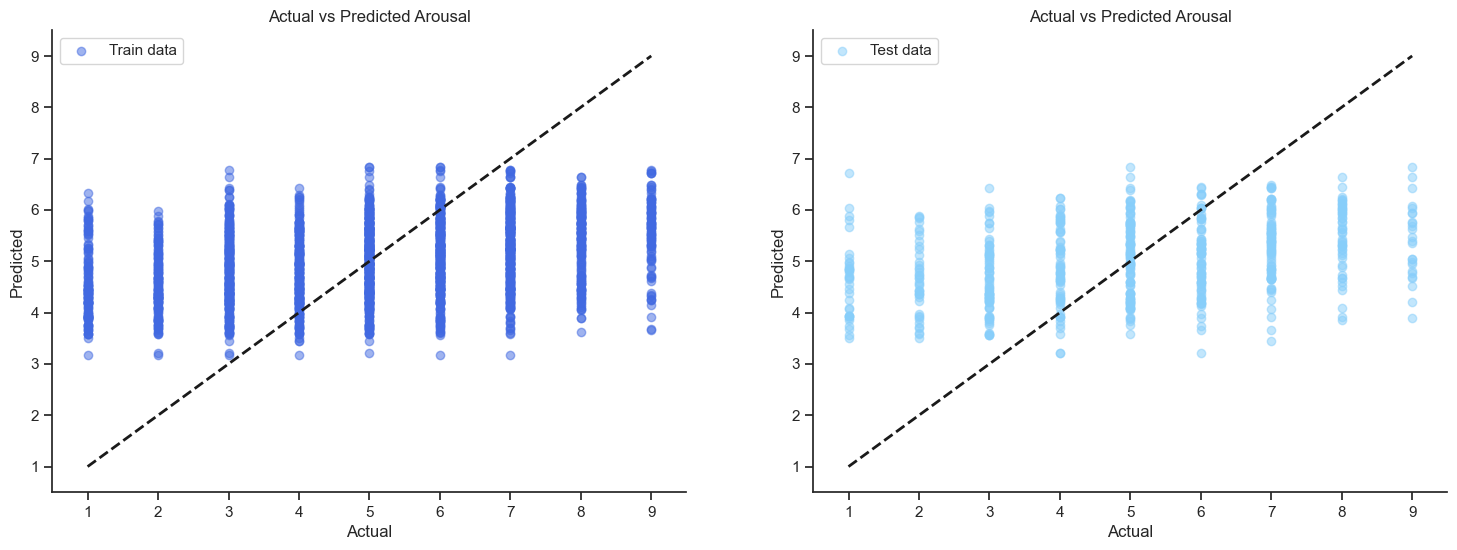

In [24]:
plot_performance(linear_model, X_train, X_test)

#### Random Forest Regression Model with Forced Entry of all Independent Variables

Since the linear regression model underfitted the data, we build and train a random forest regression model with all datapoints using the `k_folds_training` function to perform cross-validation and evaluate its performance:

- **Overfitting**: The model performs significantly better on the training set (Train R-squared: 0.302) compared to the test set (Test R-squared: -0.15), indicating overfitting.
- **Train vs. Test MSE**: 
  - **Train MSE**: Lower MSE values for all dependent variables on the training set indicate good fit to the training data.
  - **Test MSE**: Higher MSE values on the test set suggest that the model does not generalize well to unseen data.
- **Predictive Power**: The negative R-squared value for the test set (-0.15) implies that the model performs worse than a horizontal line (mean of the data), further highlighting poor generalization.

In [25]:
# Build and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(rf_model, X_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 1.845
  -Sadness Intensity: 1.53
  -Anger Intensity: 0.893
  -Fear Intensity: 1.552
  -Disgust Intensity: 0.379
  -Surprise Intensity: 1.4
  -Pleasure: 3.805
  -Arousal: 2.848
  -Dominance: 3.278
Train Average R-squared: 0.302

Test Average Mean Squared Error:
  -Joy Intensity: 2.992
  -Sadness Intensity: 2.535
  -Anger Intensity: 1.509
  -Fear Intensity: 2.588
  -Disgust Intensity: 0.625
  -Surprise Intensity: 2.284
  -Pleasure: 6.227
  -Arousal: 4.68
  -Dominance: 5.374
Test Average R-squared: -0.15


The image below shows scatter plots comparing the actual and predicted values of Arousal for both the training and test datasets using the random forest regression model. The key observations are the following:

- **Overfitting**: The Random Forest model performs significantly better on the training data than on the test data, suggesting overfitting. This is evident from the tighter clustering around the diagonal line in the training plot and the greater spread in the test plot.
- **Training Performance**: The model fits the training data reasonably well, capturing a fair amount of variability in the actual values. This is reflected in the closer alignment of predicted values to the diagonal line.
- **Test Performance**: The model struggles to generalize to the test data, with predictions showing a larger spread and deviation from the actual values. This indicates that while the model learns patterns in the training data, it fails to apply these patterns effectively to new, unseen data.
- **Bias and Variance**: The training plot suggests low bias (good fit to training data) but high variance (overfitting). The test plot suggests that this variance leads to poor generalization.

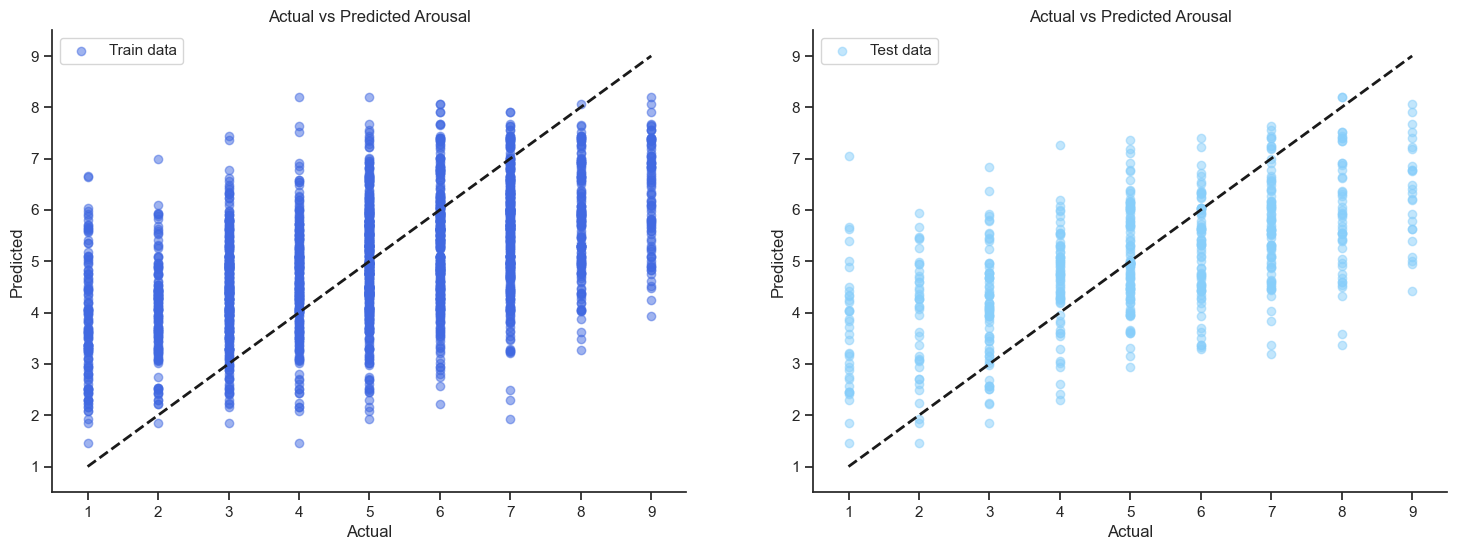

In [26]:
plot_performance(rf_model, X_train, X_test)

#### Neural Network Regression Model with Forced Entry of all Independent Variables

Finally, we also build and train a neural network model with all datapoints using the `k_folds_training` function to perform cross-validation and evaluate its performance. This neural network model includes two hidden layers with ReLU activation and an output layer with a linear activation function.

- **Moderate Improvement**: The neural network shows moderate improvement in performance compared to the linear regression model, as indicated by a higher Train R-squared (0.128) and Test R-squared (0.071).
- **Train vs. Test MSE**: The MSE values for both train and test sets are closer to each other, suggesting that the neural network has better generalization compared to the Random Forest model. However, there is still room for improvement.
- **Predictive Power**: The higher R-squared values compared to the linear regression model indicate that the neural network captures more of the variance in the dependent variables, although the values are still relatively low, implying limited predictive power.
- **Overfitting**: The difference between train and test R-squared values is smaller compared to the Random Forest model, indicating less overfitting.

Overall, the neural network model performs better than the linear regression model and shows less overfitting compared to the random forest model. However, the relatively low R-squared values suggest that there is still significant room for improvement in capturing the underlying patterns in the data.

In [27]:
# Create model
nn_model = Sequential()
nn_model.add(Input(shape=(X_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(y.shape[1], activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

nn_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(nn_model, X_scaled, y, epochs=50, batch_size=32, verbose=0)

print(f"\nTrain Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step

Train Average Mean Squared Error:
  -Joy Intensity: 2.287
  -Sadness Intensity: 1.956
  -Anger Intensity: 1.161
  -Fear Intensity: 1.93
  -Disgust Intensity: 0.495
  -Surprise Intensity: 1.781
  -Pleasure: 4.652
  -Arousal: 3.577
  -Dominance: 4.03
Train Average R-squared: 0.129

Test Average Mean Squared Error:
  -Joy Intensity: 2.478
  -Sadness Intensity: 2.097
  -Anger Intensity: 1.22
  -Fear Intensity: 2.035
  -Disgust Intensity: 0.51
  -Surprise Intensity: 1.828
  -Pleasure: 5.138
  -Arousal: 3.803
  -Dominance: 4.34
Test Average R-squared: 0.065


Finally, the image shows scatter plots comparing the actual and predicted values of Arousal for both the training and test datasets using the neural network model:

- **Improved Fit**: The neural network model shows an improved fit to the training data compared to the linear regression and random forest models. The points are more closely aligned with the diagonal line, indicating better predictions.
- **Generalization**: The model generalizes better to the test data than the random forest model, as evidenced by the relatively closer alignment with the diagonal line and a smaller spread of points. However, there is still a noticeable spread, suggesting that further tuning is needed.
- **Training Performance**: The alignment of points with the diagonal line in the training plot suggests that the neural network captures more complex relationships in the training data.
- **Test Performance**: The moderate spread in the test plot indicates that the model performs reasonably well on unseen data, though there is room for improvement.

#### Conclusion

The neural network model outperforms both the linear regression and random forest models in terms of fitting the training data and generalizing to the test data. However, the presence of spread in the test data plot suggests that further improvements are necessary to achieve better performance.

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


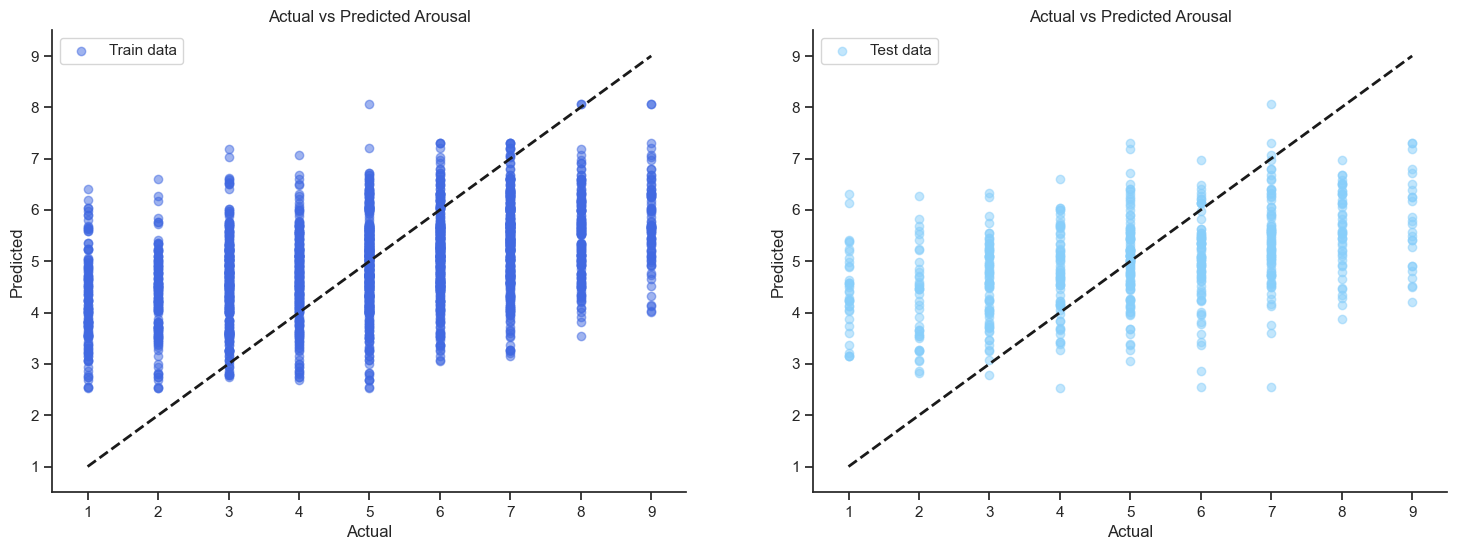

In [28]:
plot_performance(nn_model, X_train, X_test)

## Feature Engineering

### Engineering Polynomial Features with Interaction Effects

To capture interaction effects and improve the predictive power of our models, we engineered polynomial features. This process creates new features that represent all possible combinations of the original features up to a specified degree. We used the following code:

In [29]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

#### Linear Regression Model with Forced Entry of all Independent Variables and Polynomial Features with Interaction Effects

We then build and train a linear regression model with all independent variables and the engineered polynomial features using the `k_folds_training` function to perform cross-validation and evaluate its performance:

- **Improved Fit with Polynomial Features**:
  - The introduction of polynomial features with interaction effects resulted in a slight improvement in both train and test R-squared values compared to the simple linear regression model.
  - The R-squared values remain relatively low (Train: 0.097, Test: 0.052), indicating that the model still captures a limited portion of the variance in the dependent variables.
- **Train vs. Test Performance**:
  - The MSE values for both train and test sets are closer to each other, suggesting that the model generalizes better compared to the models that did not make use of the new features.
- **Effect of Forced Entry**:
  - Despite the potential for overfitting, the relatively low R-squared values suggest that the model's complexity did not lead to significant overfitting, but it also did not substantially improve predictive performance.

In [30]:
# Build and train the linear regression model
linear_model = LinearRegression()

linear_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(linear_model, X_poly_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 2.428
  -Sadness Intensity: 1.983
  -Anger Intensity: 1.166
  -Fear Intensity: 1.967
  -Disgust Intensity: 0.494
  -Surprise Intensity: 1.77
  -Pleasure: 5.0
  -Arousal: 3.64
  -Dominance: 4.214
Train Average R-squared: 0.097

Test Average Mean Squared Error:
  -Joy Intensity: 2.549
  -Sadness Intensity: 2.083
  -Anger Intensity: 1.221
  -Fear Intensity: 2.073
  -Disgust Intensity: 0.515
  -Surprise Intensity: 1.855
  -Pleasure: 5.228
  -Arousal: 3.822
  -Dominance: 4.409
Test Average R-squared: 0.052


The image below shows scatter plots comparing the actual and predicted values of Arousal for both the training and test datasets using the linear regression model with polynomial features.

- **Fit**: The linear regression model with polynomial features does not shows an improved fit to both the training and test data compared to the simple linear regression model. The points are still not closely aligned with the diagonal line, which ideally would indicate better predictions.

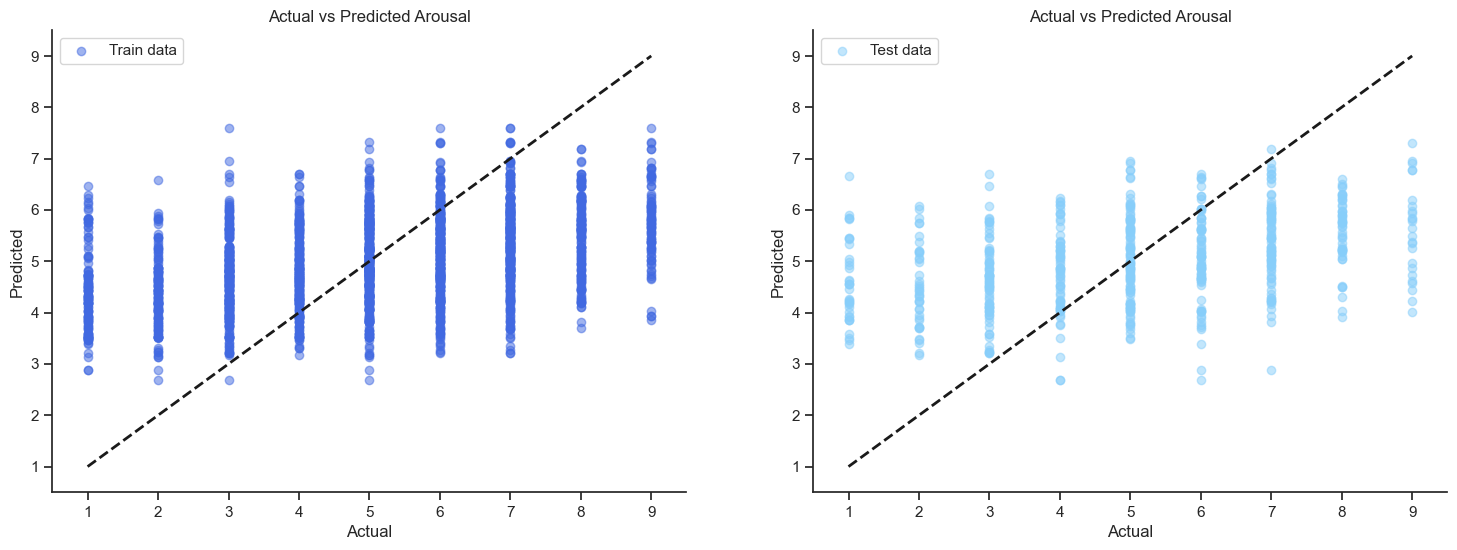

In [31]:
plot_performance(linear_model, X_train, X_test)

#### Random Forest Regression Model with Forced Entry of all Independent Variables and Polynomial Features with Interaction Effects

We then build and train a random forest regression model with all independent variables and the engineered polynomial features using the `k_folds_training` function to perform cross-validation and evaluate its performance:

- **No Improvement with Polynomial Features**:
  - The introduction of polynomial features did not improve the Random Forest model's performance. The R-squared values are identical to those obtained without polynomial features (Train: 0.302, Test: -0.15).
  - The lack of improvement suggests that the Random Forest model is already capable of capturing non-linear relationships and interaction effects without the need for polynomial features.
- **Overfitting**:
  - The model performs significantly better on the training set compared to the test set, indicating overfitting. The high train R-squared (0.302) and low test R-squared (-0.15) highlight this issue.
  - Overfitting is further evidenced by the lower MSE values on the training set and higher MSE values on the test set.
- **Training Performance**:
  - The model fits the training data well, as indicated by lower MSE values and a higher R-squared value.
- **Test Performance**:
  - The model struggles to generalize to the test data, with higher MSE values and a negative R-squared value, indicating poor predictive performance on unseen data.


In [32]:
# Build and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(rf_model, X_poly_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 1.844
  -Sadness Intensity: 1.53
  -Anger Intensity: 0.893
  -Fear Intensity: 1.552
  -Disgust Intensity: 0.379
  -Surprise Intensity: 1.4
  -Pleasure: 3.805
  -Arousal: 2.847
  -Dominance: 3.278
Train Average R-squared: 0.302

Test Average Mean Squared Error:
  -Joy Intensity: 2.991
  -Sadness Intensity: 2.535
  -Anger Intensity: 1.508
  -Fear Intensity: 2.585
  -Disgust Intensity: 0.624
  -Surprise Intensity: 2.285
  -Pleasure: 6.23
  -Arousal: 4.686
  -Dominance: 5.375
Test Average R-squared: -0.15


The image below shows scatter plots comparing the actual and predicted values of Arousal for both the training and test datasets using the linear regression model with polynomial features.

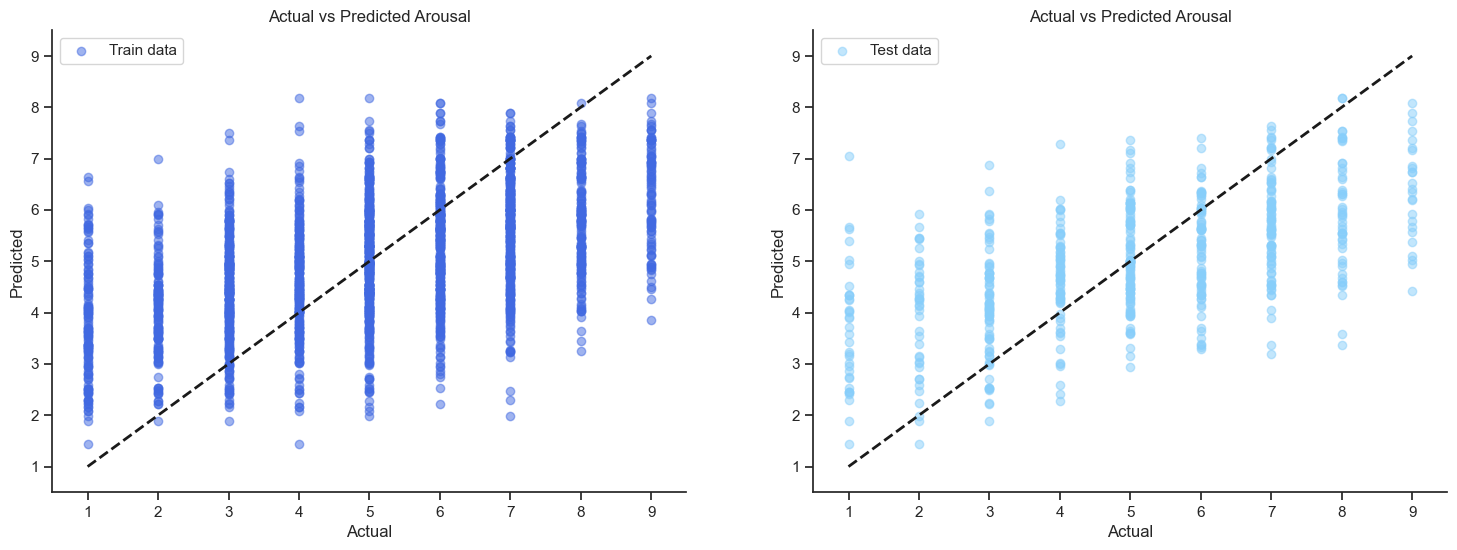

In [33]:
plot_performance(rf_model, X_train, X_test)

#### Neural Network Model with Forced Entry of All Independent Variables and Polynomial Features with Interaction Effects

We built and trained a neural network model with all independent variables and the engineered polynomial features using the `k_folds_training` function to perform cross-validation and evaluate its performance:

- **Improved Fit with Polynomial Features**:
  - The neural network model with polynomial features shows improved performance compared to the neural network without polynomial features, as indicated by higher train and test R-squared values.
  - The R-squared values (Train: 0.174, Test: 0.055) indicate that the model captures more variance in the dependent variables compared to the simple neural network model.
- **Train vs. Test Performance**:
  - The MSE values for both train and test sets are relatively close, suggesting that the model generalizes better than the random Forest model.
  - The smaller difference between train and test R-squared values indicates that the model does not suffer significantly from overfitting.
- **Predictive Power**:
  - The neural network with polynomial features demonstrates better predictive power than the linear regression and Random Forest models, capturing more complex relationships and interactions in the data.

In [ ]:
# Create model
nn_model = Sequential()
nn_model.add(Input(shape=(X_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(y.shape[1], activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

nn_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(nn_model, X_poly_scaled, y, epochs=50, batch_size=32, verbose=0)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

The image below shows scatter plots comparing the actual and predicted values of Arousal for both the training and test datasets using the neural network model with polynomial features.

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


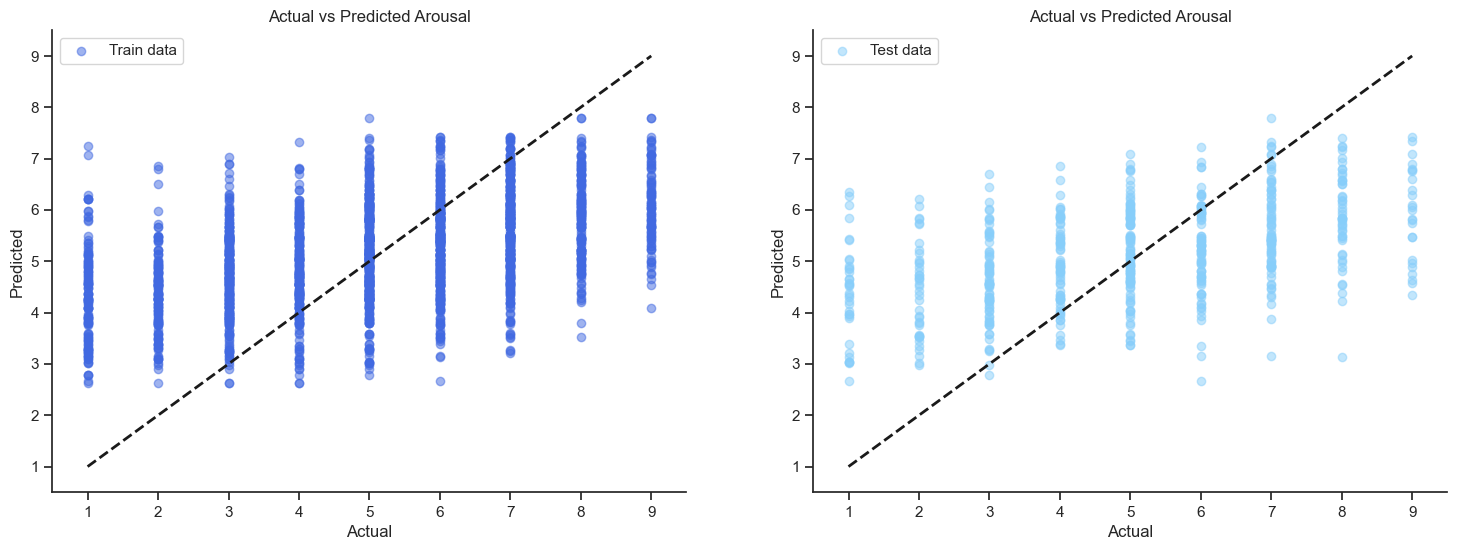

In [35]:
plot_performance(nn_model, X_train, X_test)

## Reducing Noise in Dependent Variables by Aggregation

Given the inherent noisiness of the dependent variables, we decided to group the dependent variables by `video_id` and aggregate them to find the mean, median, and mode of all dependent variables across videos. This approach aims to simplify the dependent variables and reduce noise, potentially leading to better regression models. Essentially, the models would learn to predict the mean, median, or mode of the dependent variables.

### Considerations

- **Reduced Data Points**: Since we only have 512 unique videos, aggregating the dependent variables by `video_id` results in only 512 data points. This is a significant reduction in the dataset size.
- **Impact on Model Performance**: The reduced dataset size may impact the performance of complex models, such as neural networks, which typically require larger datasets to perform well. This limitation should be considered when evaluating model performance.

In [36]:
# Aggregate the dependent variables by video_id (mean, median, and mode)
dependent_aggregated_mean = cleaned_data.groupby('video_id')[dependent_vars].mean().add_suffix('_mean')
dependent_aggregated_median = cleaned_data.groupby('video_id')[dependent_vars].median().add_suffix('_median')
dependent_aggregated_mode = cleaned_data.groupby('video_id')[dependent_vars].agg(lambda x: x.mode().iloc[0]).add_suffix('_mode')

# Add the titles of the aggregated variables
for dependent_var in dependent_vars:
    for aggregation in ['mean', 'median', 'mode']:
        dependent_aggregated_var = dependent_var + '_' + aggregation
        titles[dependent_aggregated_var] =  aggregation.title() + ' ' + titles[dependent_var]

# Merge the aggregated dependent variables with the original independent variables
aggregated_dependent_vars = pd.concat([dependent_aggregated_mean, dependent_aggregated_median, dependent_aggregated_mode], axis=1)
cleaned_data = cleaned_data.merge(aggregated_dependent_vars, on='video_id')
cleaned_aggregated_data = cleaned_data.reset_index().drop_duplicates('video_id').set_index('video_id')
cleaned_aggregated_data = cleaned_aggregated_data.drop(['start_time', 'end_time'], axis=1)

We confirm that we indeed have 512 data points now:

In [37]:
cleaned_aggregated_data.sort_index()

,wander_speed,wander_roundness,wander_cycle_rate,blink_temperature,blink_slope,blink_cycle_rate,beep_pitch,beep_slope,beep_cycle_rate,joy_intensity,...,dominance_median,joy_intensity_mode,sadness_intensity_mode,anger_intensity_mode,fear_intensity_mode,disgust_intensity_mode,surprise_intensity_mode,pleasure_mode,arousal_mode,dominance_mode
video_id,,,,,,,,,,,,,,,,,,,,,
1,87.236897,0.000103,4.757621,0.167687,-1.0,5.502769,378.842406,-1.0,5.141918,0.0,...,2.5,0.0,0.0,2.0,1.0,0.0,0.0,1.0,5.0,2.0
2,39.856034,0.627384,3.082747,0.831775,0.0,2.096989,906.623426,0.0,1.415101,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,1.0
3,52.935385,0.260046,3.387107,0.456451,1.0,0.703502,215.861748,1.0,1.976169,3.0,...,2.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0
4,75.588838,0.882944,1.713439,0.542408,0.0,4.194543,588.079762,0.0,4.413018,2.0,...,5.0,2.0,1.0,0.0,2.0,0.0,0.0,5.0,5.0,4.0
5,69.660266,0.453108,2.234201,0.660778,0.0,4.945740,153.151721,1.0,2.735729,3.0,...,5.0,3.0,2.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,69.789832,0.827974,1.541092,0.084773,-1.0,0.714256,614.235116,0.0,2.335331,4.0,...,3.0,3.0,0.0,1.0,0.0,0.0,3.0,1.0,3.0,3.0
509,75.449241,0.257818,2.406045,0.211918,-1.0,2.839445,182.836297,-1.0,3.494309,2.0,...,3.0,3.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,3.0
510,52.814612,0.885172,5.455919,0.782272,0.0,4.935008,766.868250,0.0,3.116435,4.0,...,5.0,1.0,1.0,0.0,1.0,0.0,1.0,3.0,5.0,3.0


### Target Aggregation

Next, we will select the target aggregation for the dependent variables based on how much they actually reduce the noise of the dependent variables. For this, we calculate the descriptive statistics (mean, median, standard deviation) for each of the three aggregated datasets (mean, median, mode) to compare them:

In [68]:
dependent_aggregated_mean.describe()

,joy_intensity_mean,sadness_intensity_mean,anger_intensity_mean,fear_intensity_mean,disgust_intensity_mean,surprise_intensity_mean,pleasure_mean,arousal_mean,dominance_mean
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,1.794843,1.435375,0.887598,1.335226,0.524767,1.411877,4.524800,5.040592,4.384868
std,0.843801,0.776637,0.581148,0.705349,0.332534,0.684934,1.228806,1.194781,1.034729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.600000,2.000000,1.666667
25%,1.166667,0.833333,0.428571,0.800000,0.333333,0.857143,3.666667,4.200000,3.666667
50%,1.833333,1.333333,0.833333,1.250000,0.500000,1.333333,4.600000,5.000000,4.333333
75%,2.333333,2.000000,1.200000,1.808333,0.666667,1.833333,5.333333,6.000000,5.000000
max,4.500000,4.000000,3.333333,3.500000,1.666667,3.666667,8.200000,7.666667,7.800000


In [69]:
dependent_aggregated_median.describe()

,joy_intensity_median,sadness_intensity_median,anger_intensity_median,fear_intensity_median,disgust_intensity_median,surprise_intensity_median,pleasure_median,arousal_median,dominance_median
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,1.680664,1.204102,0.665039,1.072266,0.342773,1.230469,4.418945,5.052734,4.366211
std,1.158681,0.994526,0.722580,0.951182,0.483774,0.921376,1.541269,1.413574,1.277600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,3.000000,4.000000,3.500000
50%,1.500000,1.000000,0.500000,1.000000,0.000000,1.000000,4.250000,5.000000,4.500000
75%,2.500000,2.000000,1.000000,1.500000,0.500000,2.000000,5.500000,6.000000,5.000000
max,5.000000,4.000000,4.000000,4.000000,2.000000,4.000000,9.000000,9.000000,8.000000


In [70]:
dependent_aggregated_mode.describe()

,joy_intensity_mode,sadness_intensity_mode,anger_intensity_mode,fear_intensity_mode,disgust_intensity_mode,surprise_intensity_mode,pleasure_mode,arousal_mode,dominance_mode
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,1.136719,0.714844,0.324219,0.558594,0.197266,0.757812,3.771484,4.425781,3.505859
std,1.451384,1.103603,0.688428,0.985454,0.482727,1.088967,2.176311,1.999599,1.860067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000,3.000000
75%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,5.000000,6.000000,5.000000
max,5.000000,5.000000,4.000000,5.000000,2.000000,4.000000,9.000000,9.000000,9.000000


#### Observations

- **Mean Aggregation**: results in higher mean values and lower standard deviations for most dependent variables, indicating less variability.
- **Median Aggregation**: shows slightly lower means compared to the mean aggregation but higher standard deviations, indicating moderate variability.
- **Mode Aggregation**: results in the lowest mean values and the highest standard deviations, indicating the highest variability.

#### Conclusion

The mean aggregation method appears to reduce noise effectively, resulting in less variability in the dependent variables.

In [38]:
# Select mean because it's the one that reduces noise the most
target_aggregation ='mean'

### Correlation Matrix Analysis with Aggregated Dependent Variables

Next, we can recompute the correlation matrix to see if the aggregation results in a larger effect size between each pair of independent and aggregated dependent variables.

The effect size of the correlations appears to have increased compared to the original data, indicating stronger relationships between the variables when considering aggregated values. Notable correlations include:

- **Mean Arousal and Wander Speed**: There is a strong positive correlation (0.552*), indicating that higher wander speeds are associated with higher arousal levels. This correlation is significantly stronger than in the original data.
- **Mean Sadness Intensity and Wander Speed**: There is a moderate negative correlation (-0.279*), suggesting that higher wander speeds are associated with lower sadness intensity.
- **Mean Surprise Intensity and Wander Speed**: There is a positive correlation (0.278*), indicating that higher wander speeds are associated with higher surprise intensity.
- **Mean Anger Intensity and Blink Temperature**: There is a moderate positive correlation (0.220*), suggesting that higher blink temperatures are associated with higher anger intensity.
- **Mean Fear Intensity and Beep Pitch**: There is a moderate positive correlation (0.197*), indicating that higher beep pitches are associated with higher fear intensity.

#### Interpretation

- **Increased Effect Sizes**: The correlations between the independent and dependent variables have increased in magnitude after aggregation, suggesting that aggregating the dependent variables by video_id has reduced noise and revealed stronger underlying relationships.
- **Predictive Potential**: The stronger correlations imply that the independent variables may have more predictive power for the aggregated dependent variables, potentially leading to better regression models.
- **Key Relationships**: The notable correlations, such as between wander speed and mean arousal, highlight key relationships that can be explored further for predictive modeling.


In [39]:
# Select target aggregated variable
mask = [target_aggregation in column for column in cleaned_aggregated_data.columns]
dependent_aggregated_vars = list(cleaned_aggregated_data.columns[mask])

# Compute the correlation matrix
corr_matrix = cleaned_aggregated_data[independent_vars + dependent_aggregated_vars].corr(method='pearson')

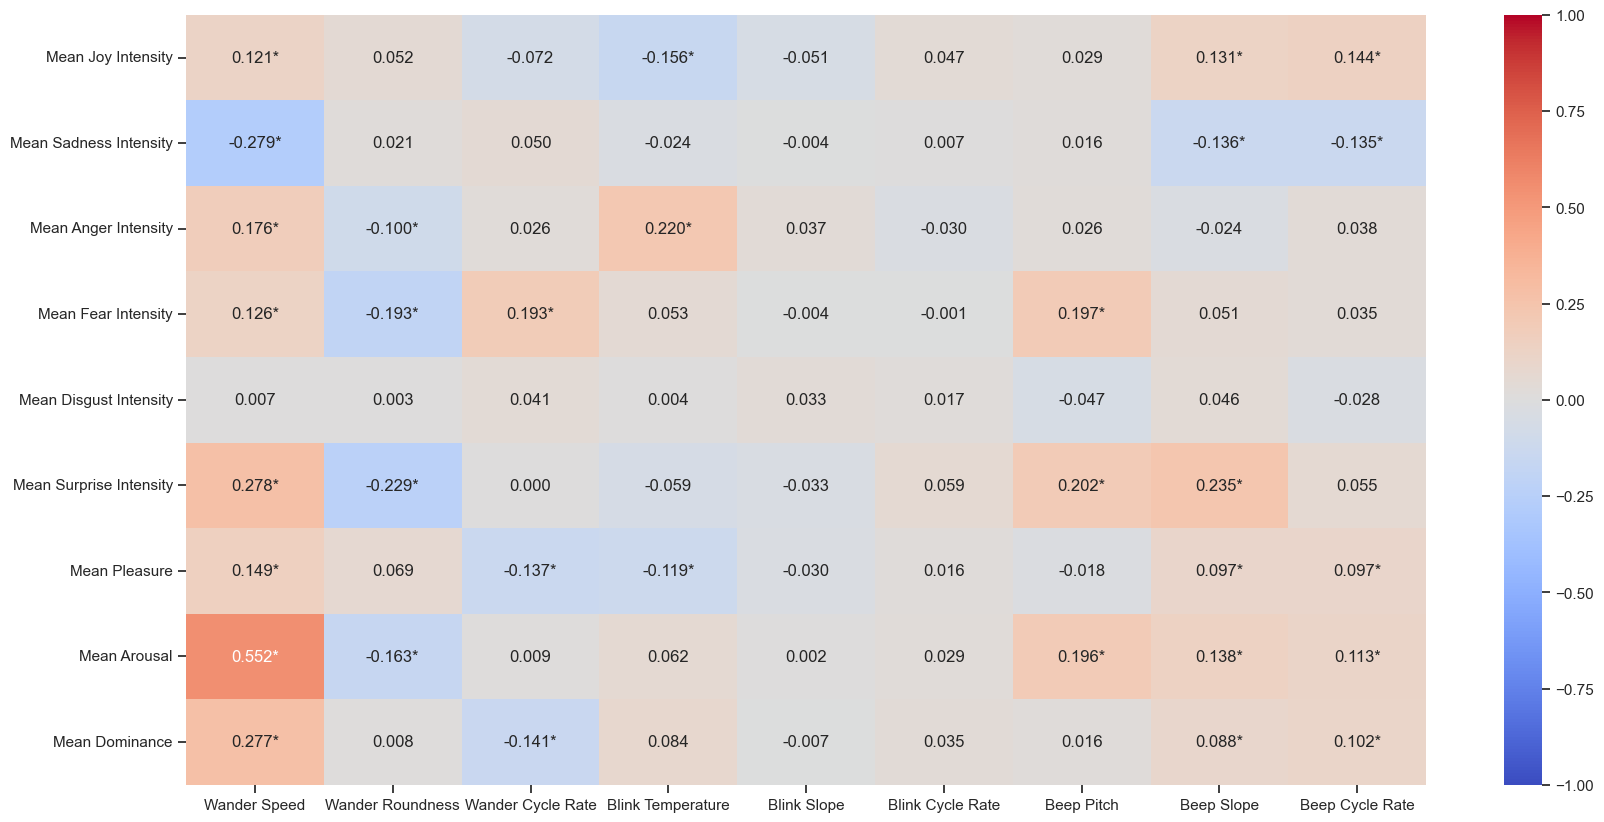

In [40]:
correlation_test_results_df = pearson_test(cleaned_aggregated_data, independent_vars, dependent_aggregated_vars)
annot = get_correlation_annots(correlation_test_results_df)

plt.figure(figsize=(20, 10))
xticklabels = [titles[var] for var in independent_vars]
yticklabels = [titles[var] for var in dependent_aggregated_vars]
sns.heatmap(corr_matrix.iloc[9:, :9], annot=annot, xticklabels=xticklabels, yticklabels=yticklabels, cmap='coolwarm', fmt='', center=0, vmin=-1, vmax=1)
plt.show()

To visualize these stronger effect sizes, we create a few scatter plots of pairs of independent variables and  aggregated dependent variable that have the highest effect size per modality.

Particularly in the Wander Speed vs. Mean Arousal plot, we can observe that this pair has a stronger linear correlation than before.

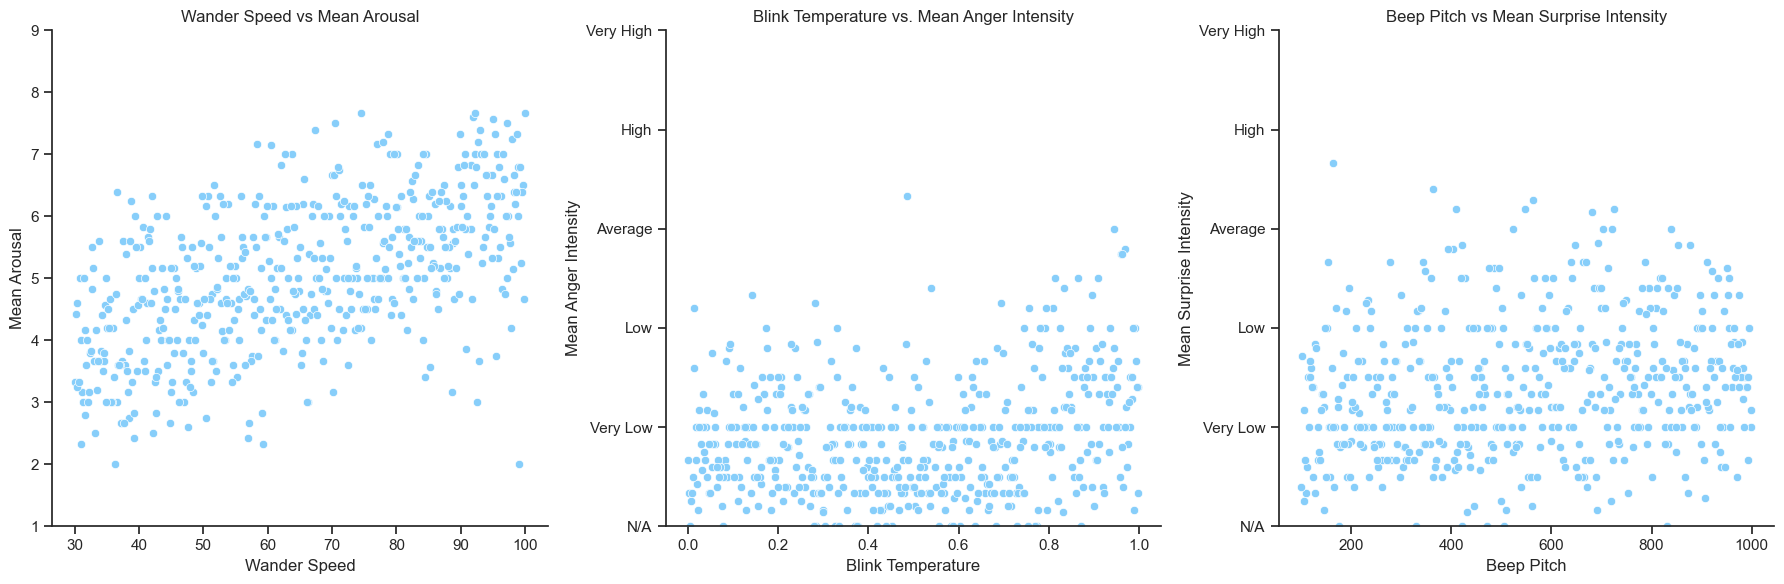

In [41]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# Scatter plot for Wander Speed vs Arousal
plt.subplot(1, 3, 1)
sns.scatterplot(data=cleaned_aggregated_data, x='wander_speed', y='_'.join(('arousal', target_aggregation)), color='lightskyblue')
plt.title('Wander Speed vs Mean Arousal')
plt.xlabel('Wander Speed')
plt.ylabel('Mean Arousal')
plt.ylim(1, 9)

# Scatter plot for Blink Temperature vs Anger Intensity
plt.subplot(1, 3, 2)
sns.scatterplot(data=cleaned_aggregated_data, x='blink_temperature', y='_'.join(('anger_intensity', target_aggregation)), color='lightskyblue')
plt.title('Blink Temperature vs. Mean Anger Intensity')
plt.xlabel('Blink Temperature')
plt.ylabel('Mean Anger Intensity')
plt.ylim(0, 5)
plt.yticks(range(0, 6), ['N/A', 'Very Low', 'Low', 'Average', 'High', 'Very High'])

# Scatter plot for Beep Pitch vs Surprise Intensity
plt.subplot(1, 3, 3)
sns.scatterplot(data=cleaned_aggregated_data, x='beep_pitch', y='_'.join(('surprise_intensity', target_aggregation)), color='lightskyblue')
plt.title('Beep Pitch vs Mean Surprise Intensity')
plt.xlabel('Beep Pitch')
plt.ylabel('Mean Surprise Intensity')
plt.ylim(0, 5)
plt.yticks(range(0, 6), ['N/A', 'Very Low', 'Low', 'Average', 'High', 'Very High'])

# Display the plots
plt.tight_layout()
plt.show()

In [42]:
# Select the independent and dependent variables
X = cleaned_aggregated_data[independent_vars]
y = cleaned_aggregated_data[dependent_aggregated_vars]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [43]:
# Build and train the linear regression model
linear_model = LinearRegression()

linear_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(linear_model, X_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Mean Joy Intensity: 0.644
  -Mean Sadness Intensity: 0.529
  -Mean Anger Intensity: 0.302
  -Mean Fear Intensity: 0.426
  -Mean Disgust Intensity: 0.109
  -Mean Surprise Intensity: 0.356
  -Mean Pleasure: 1.379
  -Mean Arousal: 0.84
  -Mean Dominance: 0.933
Train Average R-squared: 0.179

Test Average Mean Squared Error:
  -Mean Joy Intensity: 0.669
  -Mean Sadness Intensity: 0.546
  -Mean Anger Intensity: 0.33
  -Mean Fear Intensity: 0.454
  -Mean Disgust Intensity: 0.115
  -Mean Surprise Intensity: 0.373
  -Mean Pleasure: 1.447
  -Mean Arousal: 0.892
  -Mean Dominance: 0.974
Test Average R-squared: 0.128


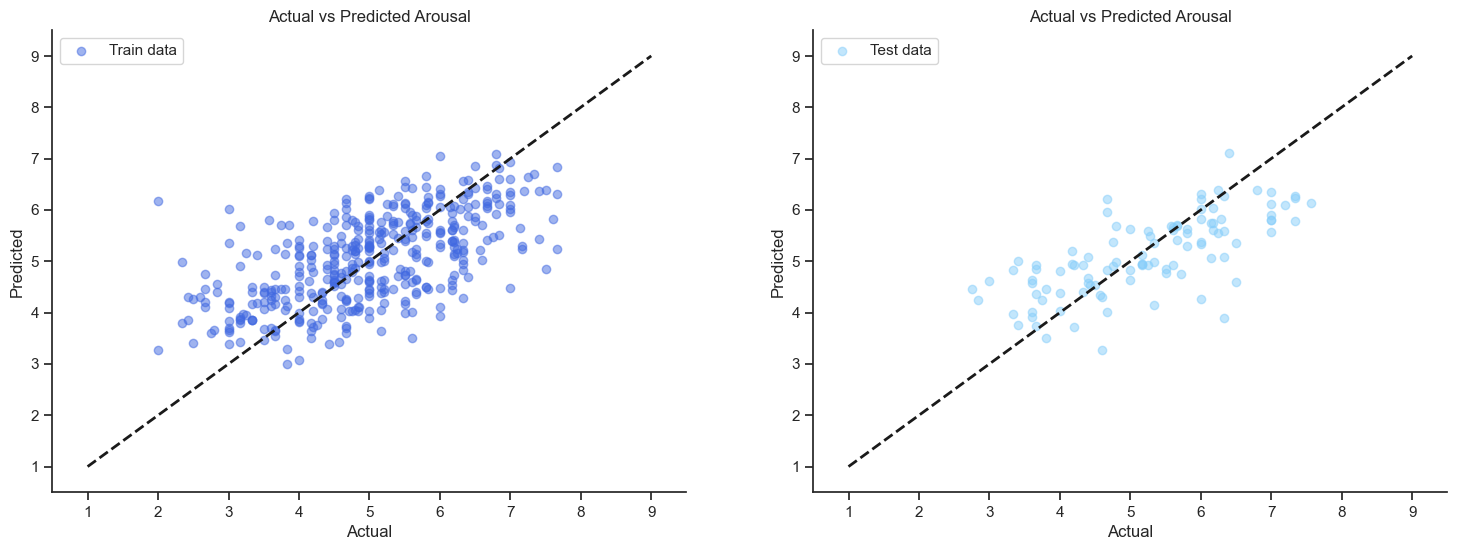

In [44]:
plot_performance(linear_model, X_train, X_test)

In [45]:
# Build and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(rf_model, X_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Mean Joy Intensity: 0.097
  -Mean Sadness Intensity: 0.074
  -Mean Anger Intensity: 0.042
  -Mean Fear Intensity: 0.064
  -Mean Disgust Intensity: 0.016
  -Mean Surprise Intensity: 0.056
  -Mean Pleasure: 0.202
  -Mean Arousal: 0.132
  -Mean Dominance: 0.142
Train Average R-squared: 0.877

Test Average Mean Squared Error:
  -Mean Joy Intensity: 0.649
  -Mean Sadness Intensity: 0.499
  -Mean Anger Intensity: 0.293
  -Mean Fear Intensity: 0.453
  -Mean Disgust Intensity: 0.111
  -Mean Surprise Intensity: 0.396
  -Mean Pleasure: 1.365
  -Mean Arousal: 0.922
  -Mean Dominance: 0.981
Test Average R-squared: 0.146


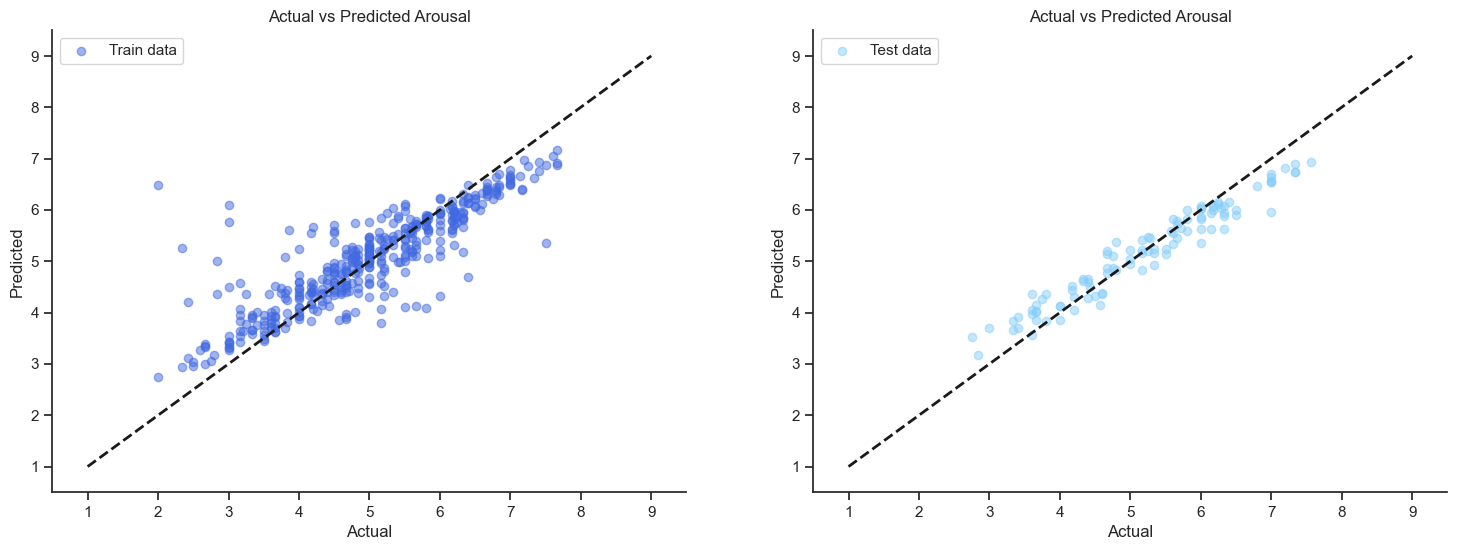

In [46]:
plot_performance(rf_model, X_train, X_test)

In [47]:
# Create model
nn_model = Sequential()
nn_model.add(Input(shape=(X_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(y.shape[1], activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

nn_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(nn_model, X_scaled, y, epochs=50, batch_size=32, verbose=0)

print(f"\nTrain Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step

Train Average Mean Squared Error:
  -Mean Joy Intensity: 0.522
  -Mean Sadness Intensity: 0.459
  -Mean Anger Intensity: 0.289
  -Mean Fear Intensity: 0.389
  -Mean Disgust Intensity: 0.106
  -Mean Surprise Intensity: 0.335
  -Mean Pleasure: 1.147
  -Mean Arousal: 0.707
  -Mean Dominance: 0.869
Train Average R-squared: 0.282

Test Average Mean Squared Error:
  -Mean Joy Intensity: 0.66
  -Mean Sadness Intensity: 0.536
  -Mean Anger Intensity: 0.324
  -Mean Fear Intensity: 0.447
  -Mean Disgust Intensity: 0.12
  -Mean Surprise Intensity: 0.37
  -Mean Pleasure: 1.466
  -Mean Arousal: 0.859
  -Me

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step


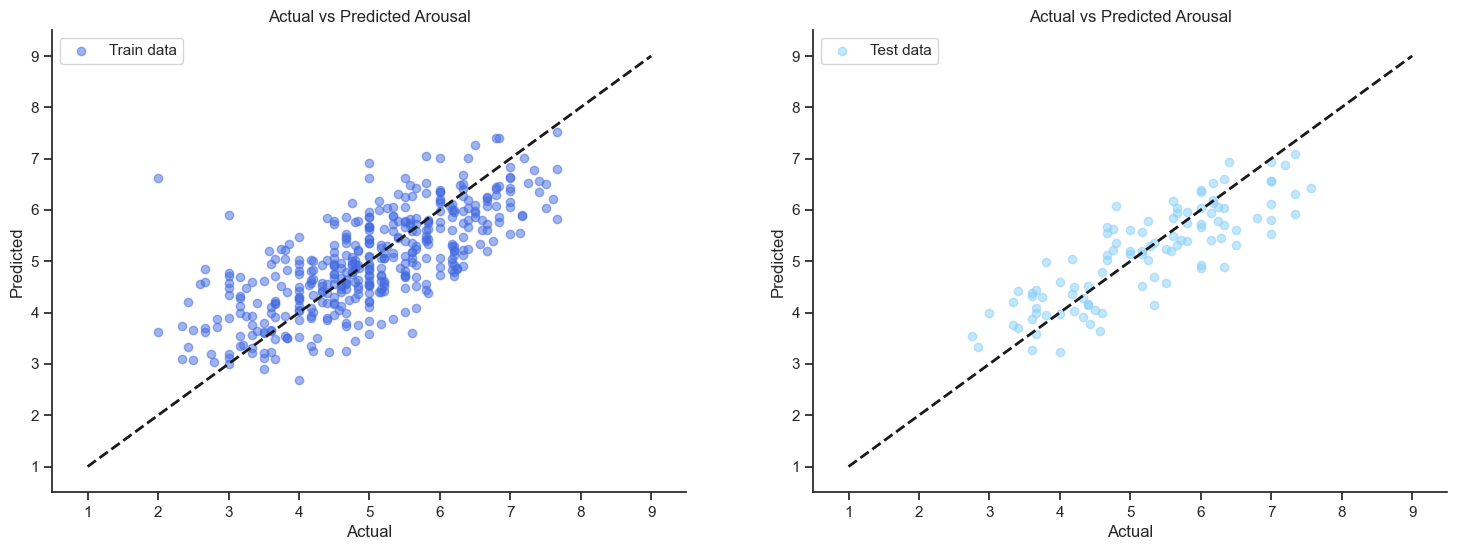

In [48]:
plot_performance(nn_model, X_train, X_test)

### Clustering with GMM and using the Membership Probabilities as Weights

The Gaussian Mixture Model is used to cluster the data points into different groups based on the distribution of the features. It allows us to identify underlying patterns in the data that can be useful for improving model performance. 

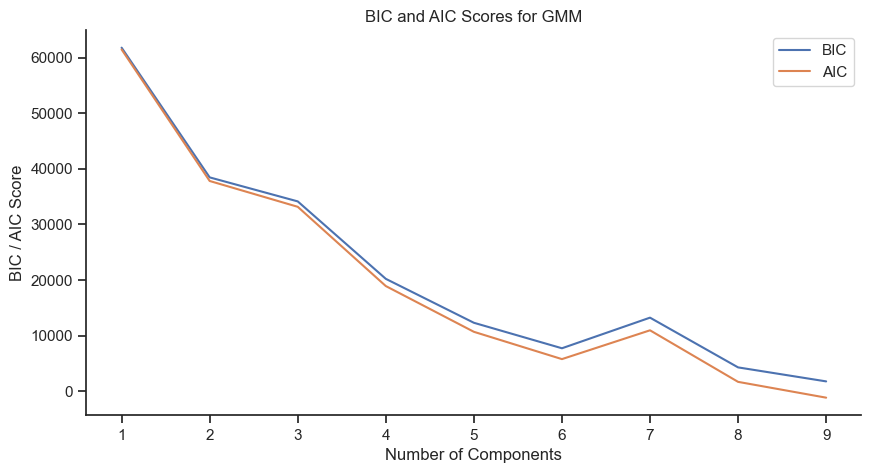

In [49]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cleaned_data[dependent_vars])

# Determine the optimal number of components using BIC and AIC
n_components_range = range(1, 10)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data_scaled)
    bics.append(gmm.bic(data_scaled))
    aics.append(gmm.aic(data_scaled))

# Plot the BIC and AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, label='BIC')
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC / AIC Score')
plt.legend()
plt.title('BIC and AIC Scores for GMM')
plt.show()

In [50]:
# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(data_scaled)
probabilities = gmm.predict_proba(data_scaled)

# Add cluster probabilities as new columns
probabilities_df = pd.DataFrame(probabilities, columns=[f'cluster_prob_{i}' for i in range(probabilities.shape[1])], index=cleaned_data.index)

cleaned_data = pd.concat([cleaned_data, probabilities_df], axis=1)

cluster_cols = list(probabilities_df.columns)

In [51]:
cleaned_data['cluster_id'] = np.argmax(cleaned_data[cluster_cols], axis=1)

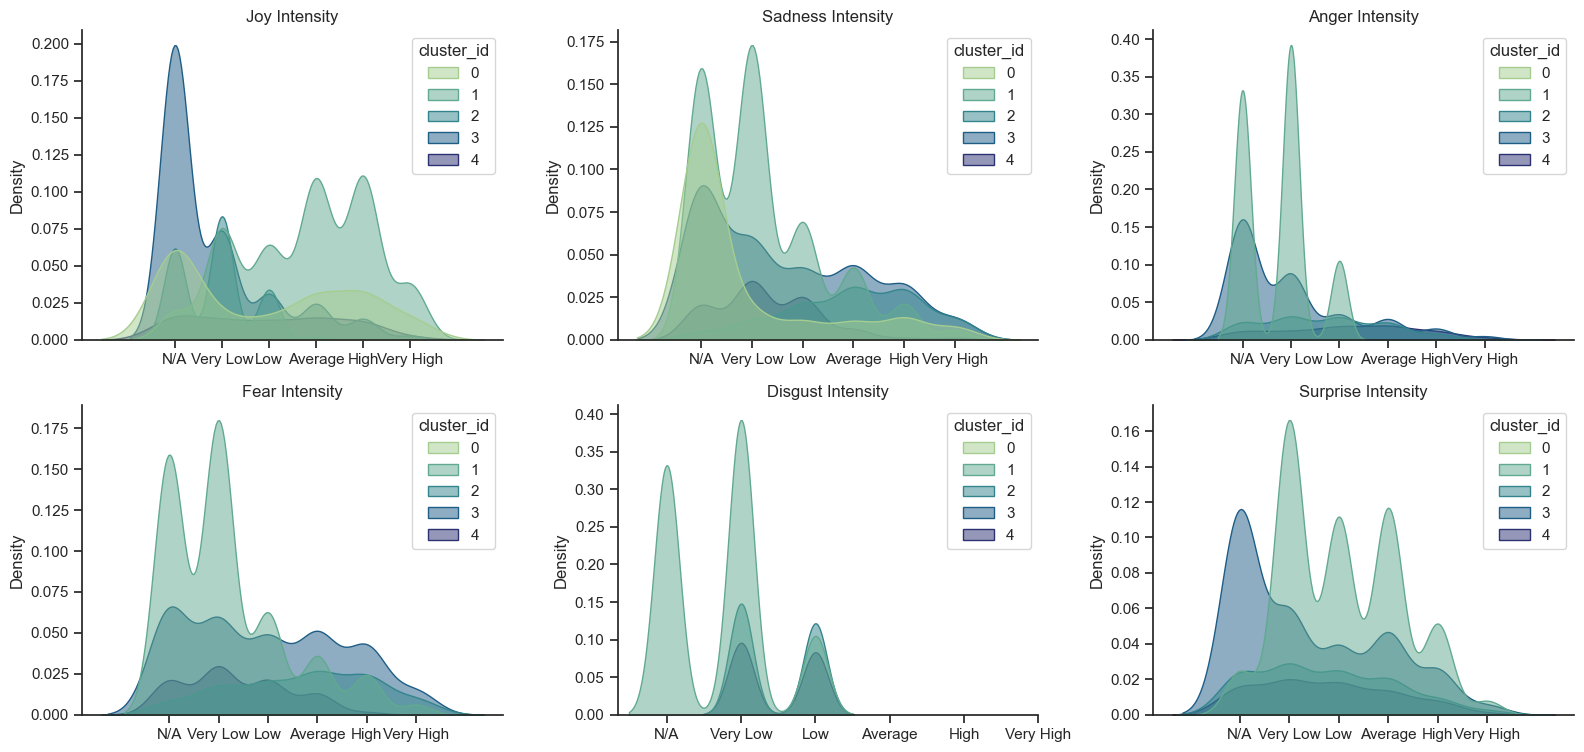

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, dependent_var in zip(axes.flatten(), intensity_columns):
    # Create the catplot in the specified subplot
    sns.kdeplot(data=cleaned_data, x=dependent_var, ax=ax, hue='cluster_id', fill=True, palette="crest", alpha=.5, warn_singular=False)
    ax.set_title(titles[dependent_var])
    ax.set_xlabel('')
    ax.set_xticks(range(6))
    ax.set_xticklabels(['N/A', 'Very Low', 'Low', 'Average', 'High', 'Very High'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

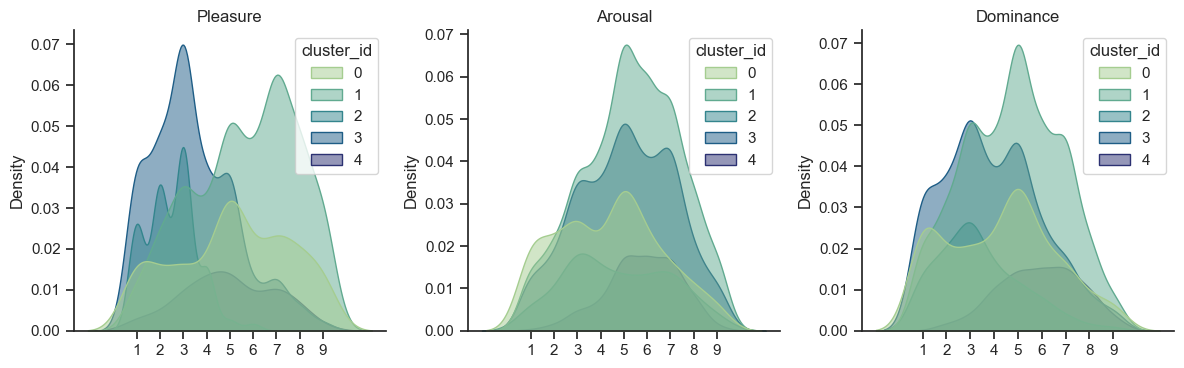

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, dependent_var in zip(axes.flatten(), sam_columns):
    # Create the catplot in the specified subplot
    sns.kdeplot(data=cleaned_data, x=dependent_var, ax=ax, hue='cluster_id', fill=True, palette="crest", alpha=.5)
    ax.set_title(titles[dependent_var])
    ax.set_xlabel('')
    ax.set_xticks(range(1,10))
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [54]:
# Select the independent and dependent variables
X = cleaned_data[independent_vars + cluster_cols]
y = cleaned_data[dependent_vars]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [55]:
# Build and train the linear regression model
linear_model = LinearRegression()

linear_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(linear_model, X_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 1.851
  -Sadness Intensity: 1.755
  -Anger Intensity: 0.88
  -Fear Intensity: 1.417
  -Disgust Intensity: 0.191
  -Surprise Intensity: 1.318
  -Pleasure: 4.05
  -Arousal: 3.743
  -Dominance: 3.951
Train Average R-squared: 0.237

Test Average Mean Squared Error:
  -Joy Intensity: 1.872
  -Sadness Intensity: 1.777
  -Anger Intensity: 0.89
  -Fear Intensity: 1.436
  -Disgust Intensity: 0.194
  -Surprise Intensity: 1.337
  -Pleasure: 4.093
  -Arousal: 3.786
  -Dominance: 3.991
Test Average R-squared: 0.227


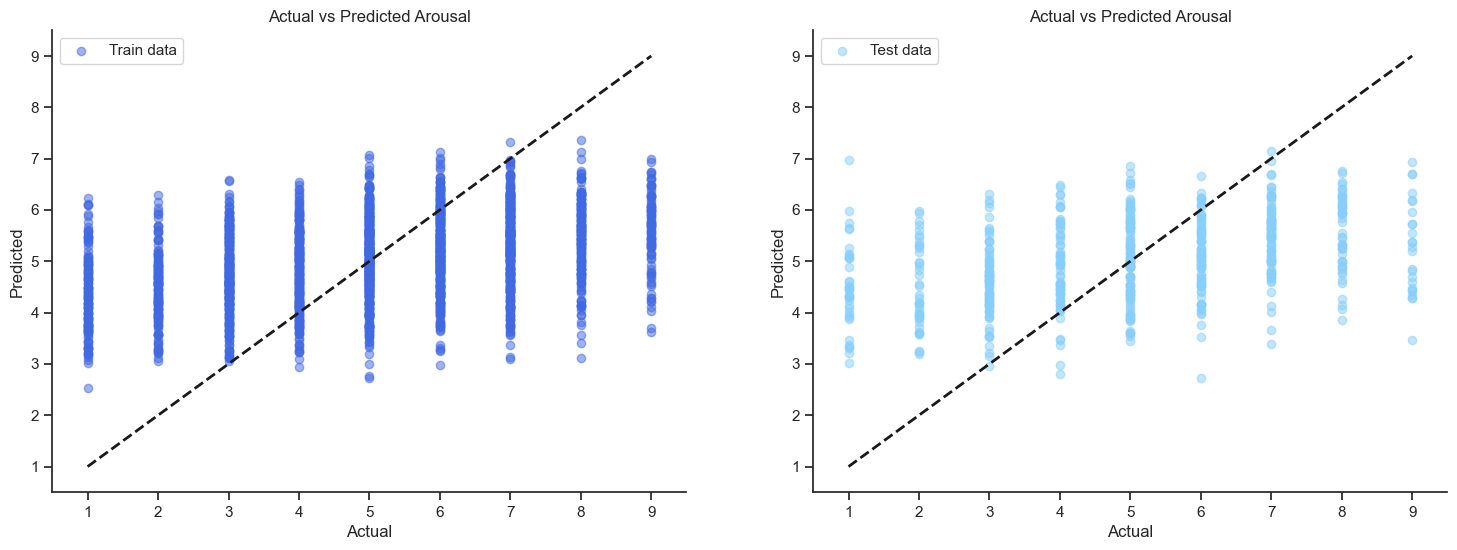

In [56]:
plot_performance(linear_model, X_train, X_test)

In [57]:
# Build and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(rf_model, X_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 0.297
  -Sadness Intensity: 0.25
  -Anger Intensity: 0.069
  -Fear Intensity: 0.111
  -Disgust Intensity: 0.011
  -Surprise Intensity: 0.175
  -Pleasure: 0.54
  -Arousal: 0.669
  -Dominance: 0.685
Train Average R-squared: 0.888

Test Average Mean Squared Error:
  -Joy Intensity: 1.258
  -Sadness Intensity: 1.157
  -Anger Intensity: 0.478
  -Fear Intensity: 0.774
  -Disgust Intensity: 0.078
  -Surprise Intensity: 1.234
  -Pleasure: 2.339
  -Arousal: 3.534
  -Dominance: 3.393
Test Average R-squared: 0.432


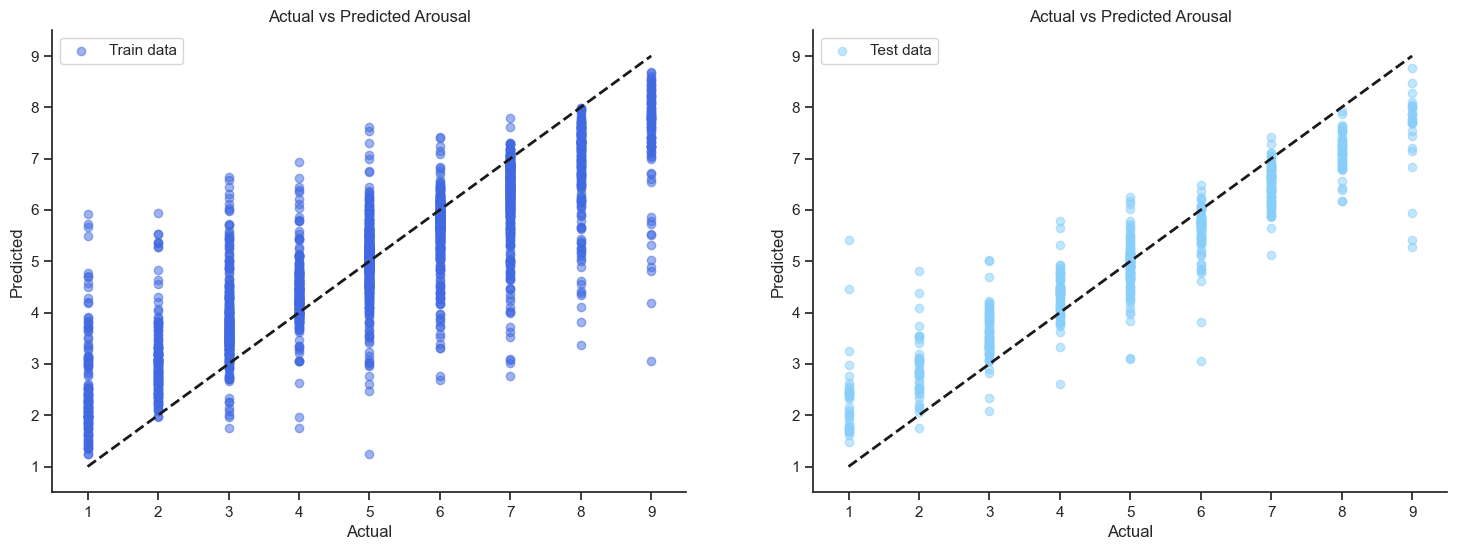

In [58]:
plot_performance(rf_model, X_train, X_test)

In [59]:
# Create model
nn_model = Sequential()
nn_model.add(Input(shape=(X_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(y.shape[1], activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

nn_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(nn_model, X_scaled, y, epochs=50, batch_size=32, verbose=0)

print(f"\nTrain Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step

Train Average Mean Squared Error:
  -Joy Intensity: 1.648
  -Sadness Intensity: 1.512
  -Anger Intensity: 0.754
  -Fear Intensity: 1.266
  -Disgust Intensity: 0.18
  -Surprise Intensity: 1.274
  -Pleasure: 3.415
  -Arousal: 3.324
  -Dominance: 3.507
Train Average R-squared: 0.327

Test Average Mean Squared Error:
  -Joy Intensity: 1.804
  -Sadness Intensity: 1.633
  -Anger Intensity: 0.799
  -Fear Intensity: 1.343
  -Disgust Intensity: 0.189
  -Surprise Intensity: 1.313
  -Pleasure: 3.874
  -Arousal: 3.589
  -Dominance: 3.9
Test Average R-squared: 0.264


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


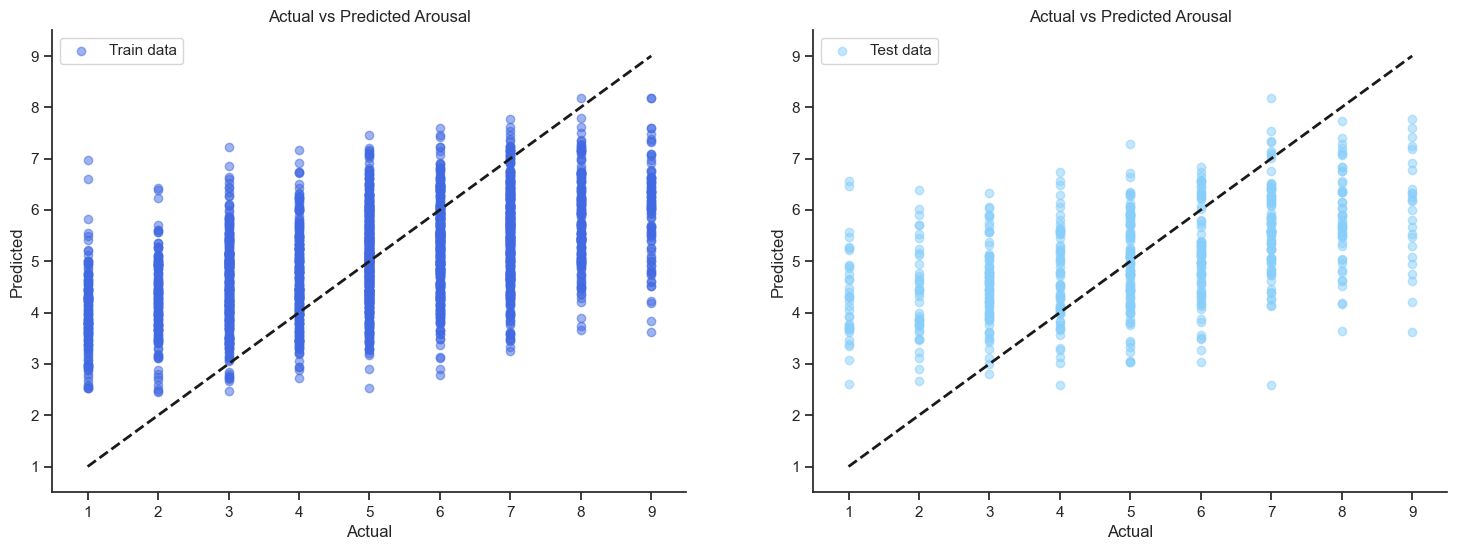

In [60]:
plot_performance(nn_model, X_train, X_test)

In [61]:
# Create polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

In [62]:
# Build and train the linear regression model
linear_model = LinearRegression()

linear_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(linear_model, X_poly_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 1.329
  -Sadness Intensity: 1.227
  -Anger Intensity: 0.707
  -Fear Intensity: 1.238
  -Disgust Intensity: 0.163
  -Surprise Intensity: 1.227
  -Pleasure: 3.041
  -Arousal: 3.38
  -Dominance: 3.467
Train Average R-squared: 0.371

Test Average Mean Squared Error:
  -Joy Intensity: 1.598
  -Sadness Intensity: 1.347
  -Anger Intensity: 0.78
  -Fear Intensity: 1.361
  -Disgust Intensity: 0.177
  -Surprise Intensity: 1.339
  -Pleasure: 3.486
  -Arousal: 3.751
  -Dominance: 3.932
Test Average R-squared: 0.291


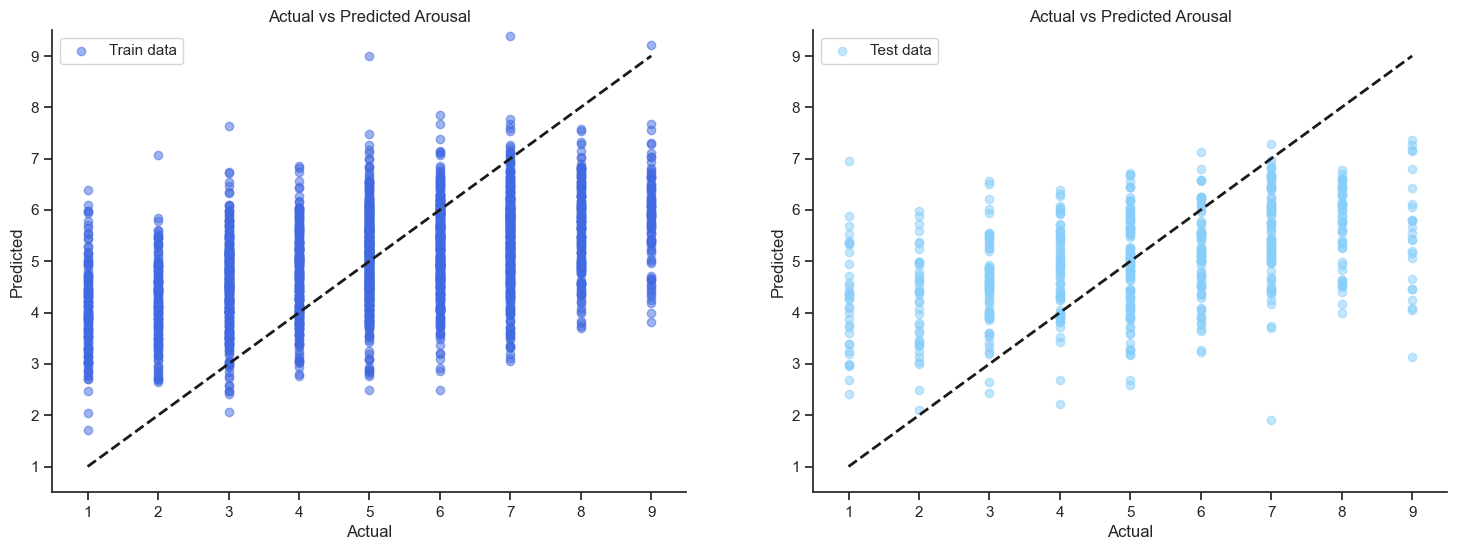

In [63]:
plot_performance(linear_model, X_train, X_test)

In [64]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(rf_model, X_poly_scaled, y)

print(f"Train Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

Train Average Mean Squared Error:
  -Joy Intensity: 0.069
  -Sadness Intensity: 0.1
  -Anger Intensity: 0.066
  -Fear Intensity: 0.106
  -Disgust Intensity: 0.011
  -Surprise Intensity: 0.172
  -Pleasure: 0.13
  -Arousal: 0.414
  -Dominance: 0.346
Train Average R-squared: 0.944

Test Average Mean Squared Error:
  -Joy Intensity: 0.496
  -Sadness Intensity: 0.705
  -Anger Intensity: 0.463
  -Fear Intensity: 0.736
  -Disgust Intensity: 0.076
  -Surprise Intensity: 1.219
  -Pleasure: 0.932
  -Arousal: 2.931
  -Dominance: 2.453
Test Average R-squared: 0.601


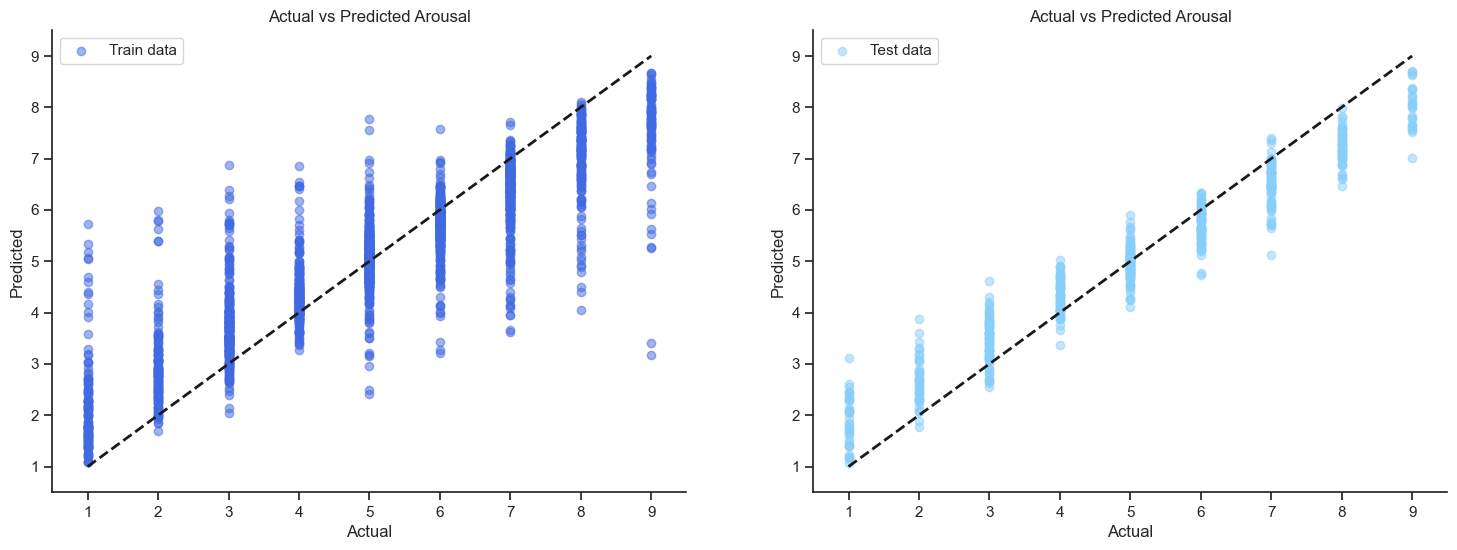

In [65]:
plot_performance(rf_model, X_train, X_test)

In [66]:
# Create model
nn_model = Sequential()
nn_model.add(Input(shape=(X_poly_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(y.shape[1], activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

nn_model, avg_train_mse_scores, avg_test_mse_scores, avg_train_r2, avg_test_r2 = k_folds_training(nn_model, X_poly_scaled, y, epochs=50, batch_size=32, verbose=0)

print(f"\nTrain Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_train_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Train Average R-squared: {avg_train_r2}\n")

print(f"Test Average Mean Squared Error:")
for dependent_var, avg_mse_score in avg_test_mse_scores.items():
    print(f"  -{titles[dependent_var]}: {avg_mse_score}")
print(f"Test Average R-squared: {avg_test_r2}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step

Train Average Mean Squared Error:
  -Joy Intensity: 0.746
  -Sadness Intensity: 0.827
  -Anger Intensity: 0.56
  -Fear Intensity: 0.885
  -Disgust Intensity: 0.148
  -Surprise Intensity: 1.153
  -Pleasure: 1.493
  -Arousal: 2.276
  -Dominance: 2.297
Train Average R-squared: 0.586

Test Average Mean Squared Error:
  -Joy Intensity: 0.997
  -Sadness Intensity: 0.99
  -Anger Intensity: 0.668
  -Fear Intensity: 1.086
  -Disgust Intensity: 0.163
  -Surprise Intensity: 1.288
  -Pleasure: 2.173
  -Arousal: 3.314
  -Dominance: 3.189
Test Average R-squared: 0.447


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


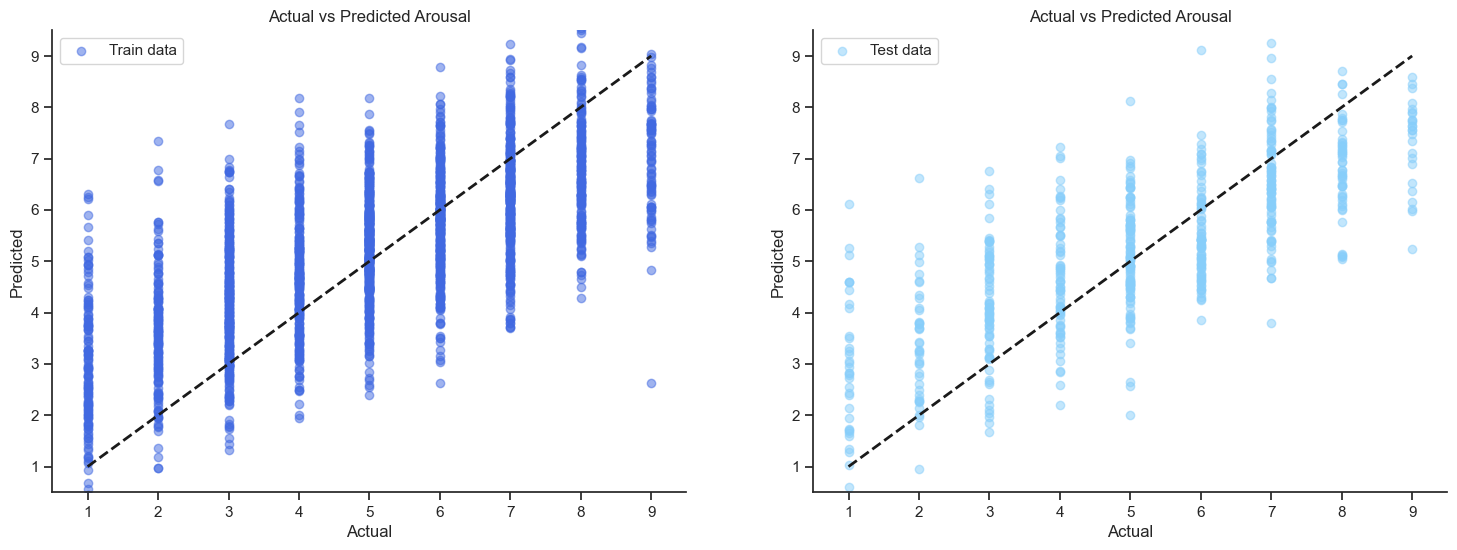

In [67]:
plot_performance(nn_model, X_train, X_test)